[![Vehicle Detection & Tracking - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)
## Dean Webb - Vehicle Detection & Tracking  Pipeline
#### Self-Driving Car Engineer Nanodegee - Project 5
In this project, my goal is to write a software pipeline to extract features from a Dataset and identify the lane boundaries within an input video. In this project, my ultimate goal was to write a software pipeline that allows for ***minimal tuning of hyperparameters*** (e.g. a linear combination of various scaled windows) and automatically extract bounding boxes from the images. The implementation would ideally detect vehicles in a video (e.g. the test_video.mp4 and the full project_video.mp4). 

To satify the project requirements, I implemented tracking using combination of 1) Sliding Windows, 2) Hog sub-sampling, 3) False-positive filtering, and 4) Re-using found vehicles (*See e.g., code cells containing functions* **`single_img_features`, `draw_single_frame_labeled_bboxes`,** and **`draw_multi_frame_labeled_bboxes`** in iPython notebook `vehicle-detection-setup.ipynb`) 

Fortunately, I was also able to install and configure the YOLO library ("You only look once") To detect vehicles! It is not optimized yet (I'm currently processing the frames by loading the weights for each frame one at a time, but it was a helpful project for learning. The project goals are listed in detail below.

---

![alt text][image8]

---

### <font color='green'>Project Goals</font>

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

### Dependencies

Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier.  These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.   You are welcome and encouraged to take advantage of the recently released [Udacity labeled dataset](https://github.com/udacity/self-driving-car/tree/master/annotations) to augment your training data.  

Some example images for testing your pipeline on single frames are located in the `test_images` folder.  To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `ouput_images`, and include them in your writeup for the project by describing what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on. 

---

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: examples/sliding_windows_code_1.jpg
[image4]: examples/sliding_window.png
[image5]: examples/bboxes_and_heat.jpg
[image6]: examples/udacity_image_augment_1.jpg
[image7]: examples/udacity_image_augment_2.jpg
[image8]: examples/yolo_predicts.jpg
[video1]: project_output_yolo.mp4
[video2]: test_output_yolo.mp4
[image10]: examples/project_car.jpg
[image11]: examples/project_noncar.jpg
[image12]: examples/udacity_car.jpg
[image13]: examples/udacity_noncar.jpg
[image14]: examples/HOG_example_project.jpg
[image15]: examples/HOG_example_udacity.jpg
[image16]: examples/SVC_Classifier.jpg
[image17]: examples/sliding_windows_code_2.jpg
[image18]: examples/search_windows_code.jpg
[image19]: examples/draw_multiframe_labels_code_1.jpg
[image20]: examples/draw_multiframe_labels_code_2.jpg
[image21]: examples/draw_multiframe_labels_code_3.jpg
[image22]: examples/sliding_windows_grid_10_thresh.jpg
[image23]: examples/sliding_windows_grid_fire.jpg
[image24]: examples/sliding_windows_grid.jpg
[image25]: examples/yolo_code.jpg



## <font color='red'> Rubric Points</font>
### Here I will consider the [rubric](https://review.udacity.com/#!/rubrics/513/view) points individually and describe how I addressed each point in my implementation below.

---

### Writeup / README

#### 1. <font color='green'>Provide a Writeup / README</font> that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.

**Done!** - *See below.*


### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained in at least code cell 12 of the accompanying IPython notebook.

I started by reading in all the `vehicle` and `non-vehicle` images. Optionally, I include a flag that augments the given dataset with the [open-sourced Udacity dataset](http://bit.ly/udacity-annoations-crowdai) (labeled from CrowdAI). To accomplish this, the pipeline downloads and extracts images from the source site, then uses the labeled bounding boxes to extract out the car images, separated by the data set.

It then also takes a snapshot above or to the bottom-left of the car image to balanace out the dataset with a `non-car` image. Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

|  Project Set Car  |Project Set NonCar|  Udacity Set Car  |Udacity Set Non-Car|
|:-----------------:|:----------------:|:-----------------:|:-----------------:|
|    ![][image10]   |   ![][image11]   |   ![][image12]    |    ![][image13]   |


I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the **`YCrCb`** color space and `HOG` parameters of **`orientations=9`, `pixels_per_cell=(8, 8)`,** and **`cells_per_block=(2, 2)`**:

|  Project Set HOG Features  |
|:--------------------------:|
|        ![][image14]        |

Below is a similar set of examples, but with the Udacity Dataset used for image augmentation.

|  Udacity Set HOG Features  |
|:--------------------------:|
|        ![][image15]        |

---

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and feature extraction techniques. Intiailly, I tried to stack the `color_histogram`, `spatial_binning`, and all channels of the `hog` technique in a feature vecture but I found the `spatial_binning` features made very many false positives when I processed the video.

I also experimented with smoothing and with many different scaling parameters, with the goal in mind to feed in as many windows as possible, then let my Vehicle class filter through the false positives. This ended up working pretty well, but there were too many false positives still. On the bad side, it took way too long to process. 

As it turns out there was a bug (it always does it seems) in my feature extraction algorithm, I realized I was converting my images to YCrCb when predicting, but I forgot to do the converting before feeding my classifier. Once I fixed the color space conversion issue, the false positives went away. In fact, it seemed to work well enough without the `spatial_binning` features, which I removed during my attempts to debug the false positives. In this regard, I utilize the `color_histogram` features after converting to `HSV`, and use the `hog` features with a) 9 orientations, b) 8 Pixels per cell, and c) 2 cells per block. The `hog` orientations works pretty well with more than 6, but I found 9 to work the best.

Additionally, I used scaling parameters to resize the images before running through the classifier. Below is an example the scaling parameters I used: 

```sh
## Parameters - HOG Sub-Sampling ##
SW_YSTART = 400
SW_YSTOP = 656
SW_SCALES = [1.0, 1.5, 1.75]
SW_CONVERT_COLOR = 'RGB2YCrCb'
```

---

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using the features listed above. Here's an example of the output in the attached iPython Notebook of the SVM classifier results. (98.85%)

|SVM Classifier Code Snippet |
|:--------------------------:|
|        ![][image16]        |

One issue that I noticed is that the classifier appears to decrease I a little the more data from the Udacity set that I add. I believe this is normal behavior since I can't be sure that my non-car features did not have some car images accidentally added in (since I added all images automatically).

---

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions at random scales all over the image. As I noted above, this experiment came with mixed results due to my earlier noted bug. Although I used HOG subsampling, I also included the sliding windows technique in my final algorithm sort of as a redundancy. Below are some parameters passed into my **`sliding_windows`**:

```sh
## Sliding Windows Parameters ##
SW_XSTART_STOPS = [(200, None), (256, 1000)]
SW_YSTART_STOPS = [(384, 640), (384, None)]
SW_XY_WINDOWS = [(96,96),(128,128)]
SW_XY_OVERLAPS = [(.450,.480),(.21,.280)]
```

Here's the **`sliding_windows`** helper functions I used to take in a list of scaling parameters:

|Sliding Windows Code Snippet|
|:--------------------------:|
|        ![][image3]         |
|        ![][image17]        |

I then used a **`search_windows`** helper function to loop through and check if the given windows contained a car image:

|Search Windows Code Snippet |
|:--------------------------:|
|        ![][image18]        |

--- 

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

As mentioned above, I implemented a combination of 1) Sliding Windows, 2) Hog sub-sampling, 3) False-positive filtering, and 4) Re-using found vehicles (*See e.g., code cells containing functions* **`single_img_features`, `draw_single_frame_labeled_bboxes`,** and **`draw_multi_frame_labeled_bboxes`** in iPython notebook `vehicle-detection-setup.ipynb`). I searched on multiple scales using a conversion to `YCrCb` (and all 3-channels of `HOG` features plus color histograms in the `HSV` colorspace) The combination of these techniques are then wrapped in a flag to turn them on and off, which provided a nice way of testing their influence to the final bounding boxes. Here's a code snippet of the pipeline processing a video frame being: 

|Video Pipeline Code Snippet |
|:--------------------------:|
|        ![][image19]        |

Here are some example images that were output (in this case from the function **`draw_single_frame_labeled_bboxes`**):

|Single Frame Example Images |
|:--------------------------:|
|        ![][image4]         |

---

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](project_output_no_yolo.mp4).


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions. I then used **`scipy.ndimage.measurements.label()`** to identify individual blobs in the heatmap. Since I ultimately decided to apply multiple techniques at the same time, I created a list of labels from each respective technique, then merged the results together. I then assumed each remaining blob in the heatmap corresponded to a detected vehicle, so I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of **`scipy.ndimage.measurements.label()`** and the bounding boxes then overlaid on the last frame of video. Here are example frames and their corresponding heatmaps:

|Heatmap and Labels Examples |
|:--------------------------:|
|        ![][image5]         |


Note that the the resulting bounding boxes are drawn onto the last frame in the series.

---

### <font color='red'>Discussion / Learnings / Shortcomings</font>

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.

At first, due to errors in my implementation, I had much trouble getting the SVM classifer to predict much of anything correctly. This I found out much later was because I forgot to convert the image to 'YCrCb' before extrracting the `hog` features, although I performed the conversion right before prediction. 

As a way to increase the accuracy (and decrease false positives), I include a flag that augments the given dataset with the [open-sourced Udacity dataset](http://bit.ly/udacity-annoations-crowdai) (labeled from CrowdAI). To accomplish this, the pipeline downloads and extracts images from the source site, then uses the labeled bounding boxes to extract out the car images, separated by the data set. Some code snippets are printed below:

|Udacity Dataset Augmentation|
|:--------------------------:|
|        ![][image6]         |
|        ![][image7]         |

As noted above, my combination of 1) Sliding Windows, 2) Hog sub-sampling, 3) False-positive filtering, and 4) Re-using found vehicles (*See e.g., the code cells containing functions* **`single_img_features`, `draw_single_frame_labeled_bboxes`,** and **`draw_multi_frame_labeled_bboxes`** in iPython notebook `vehicle-detection-setup.ipynb`) seems to work pretty well.

For extra practice and added redundancy, I also implemented **YOLO** to investigate/compare how well this network processed the images compared to my original algorithm. 

---

##### <font color='green'>Learnings</font>
For the HOG-subsampling and sliding windows techniques, I used a somewhat limited region to search, this was to limit the false positives from the trees or the roads. Additionally, I tried to combat false positives with an image augmentation approach that utilizes the Udacity dataset. I did this by creating a bounding box to the ***lower left*** (to mimic roads) or ***directly above*** (to mimic skies) the ground truth labels.

Here's some example images that shows how much of a disaster the prediction windows were at first:

| Sliding Windows False Postives  |
|:-------------------------------:|
|           ![][image22]          |
|           ![][image23]          |
|           ![][image24]          |

---

##### <font color='red'>Shortcomings</font>
The biggest issue I noticed was the bounding box not always bounding the entire car image within a box. I believe this is due to the smaller windows in my implementation tending to pick up the image first. I implement a matching schemed on the boxes, which causes the b=size of the box to gradually rise. Along those lines, the boxes disappear once the car starts to disappear fromt he frame. To fix the latter issue, I could augment my dataset with more pictures of car images that are halved or warped by some other means.

I could have spent another few weeks on this project perfecting it. One optimization I had considered was to completely train the YOLO network on my augmented Udacity dataset (discussed above). This I believe will help with **YOLO** dropping its detection from time to time. Below is a code snippet on how I processed the frames with YOLO:

|YOLO Code Snippet |
|:----------------:|
|   ![][image25]   |

I ran out of time, but my next experiment was going to be to hopefully use the bounding boxes predicted from **YOLO** as it's own feature extractor somehow to make the image detection more robust and less error prone. My thinking here is I could extract out the bounding boxes using the bounding box color as a pixel value to search for. Once I extracted the boxes, I could integrate them with my `Vehicle()` class for storing and reusing.

##  Load Dataset and Preproceses Images

### Imports

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from PIL import Image
import time
import os
import zipfile as zf
import tarfile
import csv
import pickle
import urllib
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import pandas as pd

### Constants

In [134]:
## Dataset Parameters ##
TRAINING_DATASET_DIRECTORY = 'training_set/'
PIPELINE_SETUP_DIRECTORY = 'pipeline_setup_images/'
WORKING_DIRECTORY = 'data/'
NON_VEHICLES_TOKEN = 'non-vehicles'
dataset_path = "{}{}{}{}".format(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY,'**/', '*.png')
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')
PROJECT_SOURCE_URL = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking'
VEHICLES_ZIPFILE = 'vehicles.zip'
NONVEHICLES_ZIPFILE = 'non-vehicles.zip'


## Udacity Dataset Extraction Parameters ##
LABELS_CSV = 'data/object-detection-crowdai/labels.csv'
UDACITY_SOURCE_URL = 'http://bit.ly/udacity-annoations-crowdai'
DATASET_ZIPFILE = 'object-detection-crowdai.tar.gz'
UDACITY_DATASET_DIRECTORY = 'udacity-set'
APPEND_UDACITY_DATASET = False
UDACITY_AUGMENT_PCT = 0.015

## Image Processing ##
DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH = (64, 64, 3)
if DEFAULT_DEPTH > 1:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH, DEFAULT_DEPTH)
else:
    DEFAULT_RESOLUTION = (DEFAULT_LENGTH, DEFAULT_WIDTH)

## Feature Extraction Parameters ##
# Spatial Binning
SPATIAL = 64
BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
HIST_NBINS = 128
COLOR_SPACE = 'HSV'
# HOG Parameters
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = 8
HOG_CELLS_PER_BLOCK = 2
HOG_CHANNEL = 'ALL' # Can be 0, 1, 2, or "ALL"
SW_SPATIAL_FEAT_FLAG = False
SW_HOG_FEAT_FLAG = True
SW_COLOR_HIST_FEAT_FLAG = True

## Training Parameters ##
# SVC Parameters
VALIDATION_PORTION = .2
N_PREDICTIONS = 100
OVERWRITE_DATACACHE = True

### Helper Functions - Udacity Dataset Loading & Augmentation

In [11]:
# Define a function to scale .PNG and JPEG Files both to 0 to 1 
def normalize_pixels(img):
    max_pixel_value = np.max(img)
    if max_pixel_value > 1.0:
        img = np.copy(np.multiply(img, 1.0 / 255.0)).astype(np.float64)
    return img

# Define a function to scale .PNG and JPEG Files both to 0 to 1 
def denormalize_pixels(img):
    max_pixel_value = np.max(img)
    if max_pixel_value <= 1.0:
        img = np.copy(np.multiply(img, 255.0)).astype(np.float64)
    return img

def process_img(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image/255.-.5
    return image

In [5]:
def maybe_download(source_url, filename):
    if not os.path.exists(WORKING_DIRECTORY):
        os.mkdir(WORKING_DIRECTORY)
    
    filepath = os.path.join(WORKING_DIRECTORY, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(source_url, filepath)
        statinfo = os.stat(filepath)
        print('')
        print('Succesfully downloaded:', filepath, '| % d MB.' % int(statinfo.st_size*1e-6))
    return filepath

In [6]:
def unzip_file(zip_file, source_dir_name=None, destination=WORKING_DIRECTORY):
    if 'tar.gz' in zip_file:
        head, tail = os.path.splitext(zip_file)
        if not os.path.exists(os.path.join(os.path.splitext(head)[0])):
            print('unzipping file:', zip_file, 'to directory:', os.path.join( os.path.splitext(head)[0]))
            tar = tarfile.open(zip_file, "r:*")
            tar.extractall(destination)
            tar.close()
    else: #.zip extension
        head, tail = os.path.splitext(zip_file)
        #print('Target Dir', os.path.join(destination, head))
        if not os.path.exists(os.path.join(destination, head)):
            print('File does not exist: ', os.path.join(destination, head), ': Extracting')
            zipf = zf.ZipFile(os.path.join(WORKING_DIRECTORY,zip_file))
            print('Loaded zipf',zipf, ': Extracting')
            zipf.extractall(os.path.join(destination, head))
            zipf.close()

In [13]:
vehicles_zipfile = maybe_download(os.path.join(PROJECT_SOURCE_URL,VEHICLES_ZIPFILE), VEHICLES_ZIPFILE)
source_dir_name, fname = os.path.split(vehicles_zipfile)
unzip_file(fname, source_dir_name=source_dir_name, destination=os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY))

non_vehicles_zipfile = maybe_download(os.path.join(PROJECT_SOURCE_URL,NONVEHICLES_ZIPFILE), NONVEHICLES_ZIPFILE)
source_dir_name, fname = os.path.split(non_vehicles_zipfile)
unzip_file(fname, source_dir_name=source_dir_name, destination=os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY))

## Udacity Dataset
tar_file = maybe_download(UDACITY_SOURCE_URL, DATASET_ZIPFILE)
unzip_file(tar_file)

cars_dir = os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY, 
                         'vehicles', UDACITY_DATASET_DIRECTORY)
os.makedirs(cars_dir, exist_ok=True)
noncars_dir = os.path.join(WORKING_DIRECTORY, TRAINING_DATASET_DIRECTORY, 
                         'non-vehicles', UDACITY_DATASET_DIRECTORY)
os.makedirs(os.path.join(noncars_dir, 'skies'), exist_ok=True)
os.makedirs(os.path.join(noncars_dir, 'roads'), exist_ok=True)

In [14]:
## Extract Labels ##
HEADER_ROW=['xstart', 'ystart', 'xstop', 'ystop', 'frame', 'label', 'preview_url']
annotations = pd.read_csv(LABELS_CSV, names=HEADER_ROW, skiprows=1)
annotations.head()

xstart  ystart  xstop  ystop                    frame  label  \
0     785     533    905    644  1479498371963069978.jpg    Car   
1      89     551    291    680  1479498371963069978.jpg    Car   
2     268     546    383    650  1479498371963069978.jpg    Car   
3     455     522    548    615  1479498371963069978.jpg  Truck   
4     548     522    625    605  1479498371963069978.jpg  Truck   

                                         preview_url  
0  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
1  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
2  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
3  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...  
4  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...

In [15]:
def extract_and_preprocess_image(filepath, cars_dir, noncars_dir, xstart, ystart, xstop, ystop,
                                 img_size=(DEFAULT_LENGTH, DEFAULT_WIDTH), img_ext = '.png'):
    full_path = os.path.join(WORKING_DIRECTORY, 'object-detection-crowdai', filepath)
    # Image read in from cv2 + .jpg -> (0 to 1)
    if os.path.exists(full_path) or OVERWRITE_UDACITY_DATASET == True:
        # Use cv2 to open image and extract bounding boxes
        img = process_img(full_path)
        # boxed_img = im[y:y+h,x:x+w]
        # Extract Car Image. Note: numpy arrays are (row, col)!
        
        car_img = img[ystart:ystop, xstart:xstop]
        resized_car_img = cv2.resize(car_img, img_size, interpolation=cv2.INTER_AREA)
        im = Image.fromarray(resized_car_img)
        # Save Car Image to corresponding Directory
        filename, ext = os.path.splitext(filepath)
        new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'car', xstart, ystart, xstop, ystop, img_ext)
        im.save(os.path.join(cars_dir, new_filename)) # Save as .png
        im.close
        
        # Auto-Generate a 'Non-Car' Image to keep dataset balanced
        i_lrc = np.random.randint(3) # 66% chance of auto generating non-car features
        if (i_lrc == 0):
            xstart_mod, ystart_mod, xstop_mod, ystop_mod = xstart, \
                                                    (0 if ystart-(ystop-ystart) < 0 else ystart-(ystop-ystart)), xstop, ystart
            new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'sky', xstart_mod, ystart_mod, xstop_mod, ystop_mod, img_ext)
            path_file = os.path.join(noncars_dir,'skies', new_filename)
        elif (i_lrc == 1):
            xstart_mod, ystart_mod, xstop_mod, ystop_mod = xstart, ystop, xstop, \
                                                    (img_shape[0] if ystop+(ystop-ystart) > img_shape[0] else ystop+(ystop-ystart))
            new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'road', xstart_mod, ystart_mod, xstop_mod, ystop_mod, img_ext)
            path_file = os.path.join(noncars_dir, 'roads', new_filename)
            
        noncar_img = scaled_img[ystart_mod:ystop_mod, xstart_mod:xstop_mod]
        resized_noncar_img = cv2.resize(noncar_img, img_size, interpolation=cv2.INTER_AREA)
        # Save noncar image to corresponding Directory
        im = Image.fromarray(resized_noncar_img)
        filename, ext = os.path.splitext(filepath)
        im.save(path_file) # Save as .png
        im.close

### Extract Features from Dataset

In [16]:
## Extract Labels ##      
for label in annotations.as_matrix():
    filename, ext = os.path.splitext(label[4])
    new_filename =  "{}_{}_{}_{}_{}_{}{}".format(filename,'car', label[0], label[1], label[2], label[3], '.png')
    if not os.path.exists(os.path.join(cars_dir, new_filename)) and label[5].lower() == 'car':
        try:
            extract_and_preprocess_image(label[4], cars_dir, noncars_dir, xstart=label[0], ystart=label[1],
                                     xstop=label[2], ystop=label[3])
        except:
            print("Error extracting label:", label, " Moving on..")

Error extracting label: [912 0 951 0 '1479498564477313399.jpg' 'Car'
 'http://crowdai.com/images/k-zz9yqpJIit7OuX/visualize']  Moving on..
Error extracting label: [705 0 732 0 '1479498820473341507.jpg' 'Car'
 'http://crowdai.com/images/Ng_nd_wBlqkgNDGb/visualize']  Moving on..
Error extracting label: [721 0 751 0 '1479499937073018706.jpg' 'Car'
 'http://crowdai.com/images/sbjD-93YWUi9hJ0c/visualize']  Moving on..


### Extract Features from Dataset - Helper Functions

Define a function to compute `spatial binned` pixel intensity features:

In [17]:
def bin_spatial(img, size=BIN_SPATIAL_SIZE):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3)) 


Define a function to compute `color histogram` features:

In [18]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=HIST_NBINS):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features


Define a function to compute `hog` features:

In [45]:
# Define a function to return HOG features and visualization --
def get_hog_features(img_chan, orient=HOG_ORIENTATIONS,
                     pix_per_cell=HOG_PIXELS_PER_CELL,
                     cell_per_block=HOG_CELLS_PER_BLOCK, 
                     vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img_chan, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img_chan, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### Download and Preprocess Udacity Dataset

In [46]:
# Define a function to extract features from a list of images
def extract_features(imgs, cspace=COLOR_SPACE, spatial_size=BIN_SPATIAL_SIZE,
                        hist_bins=HIST_NBINS):
    # Create a list to append feature vectors
    features = []
    for file in imgs:       
        image = mpimg.imread(file)
        
        # Image read in from cv2 + .png -> (0 to 1) scaled
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_image = np.copy(cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb))
        
        hog_shape = np.asarray(hog_image.shape)
        if HOG_CHANNEL == 'ALL':
            hog_features = []
            for channel in range(len(hog_shape)):
                hog_features.append(get_hog_features(hog_image[:,:,channel]))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(hog_image[:,:,HOG_CHANNEL])
        
        # Append the new feature vector to the features list
        # Allow for flagged setting of feature vectors (spatial, hist, hog) must maintain the ordering
        if(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((hist_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
            features.append(np.array(hog_features))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
            features.append(np.concatenate((spatial_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == False):
            features.append(np.array(spatial_features))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
            features.append(np.concatenate((spatial_features, hist_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
            features.append(np.array(hist_features))
        else:
            features.append(np.concatenate(feature_image))
        
    # Return list of feature vectors
    return features

### Begin Training Pipeline

In [15]:
## Starting Training Pipeline ##
# Load Image Paths 
images = glob.glob(dataset_path, recursive=True)
cars = []
notcars = []
udacity_cars = []
udacity_notcars = []
for image in images:
    if UDACITY_DATASET_DIRECTORY in image:
        if NON_VEHICLES_TOKEN in image:
            udacity_notcars.append(image)
        else:
            udacity_cars.append(image)
    else:
        if NON_VEHICLES_TOKEN in image:
            notcars.append(image)
        else:
            cars.append(image)

assert len(images) == len(cars) + len(notcars) + len(udacity_cars) + len(udacity_notcars), 'The subarrays have not split the dataset correctly.'
print('Number of Vehicle Images Found:',len(cars))
print('Number of Non-Vehicle Images Found:',len(notcars))
    
if APPEND_UDACITY_DATASET == True: #Using to Keep Dataset separate
    udacity_augment_size = np.int(len(udacity_cars)*UDACITY_AUGMENT_PCT)
    udacity_cars, udacity_notcars = np.array(udacity_cars), np.array(udacity_notcars)
    
    ind = np.random.random_integers(0, len(udacity_cars)-1, udacity_augment_size)
    cars.extend(list(udacity_cars[ind]))
    ind = np.random.random_integers(0, len(udacity_notcars)-1, udacity_augment_size)
    notcars.extend(list(udacity_notcars[ind]))
else:
    num_udacity_features = np.int(len(udacity_cars)*UDACITY_AUGMENT_PCT)
    udacity_cars, udacity_notcars = np.array(udacity_cars), np.array(udacity_notcars)
    
    udacity_features_ind = np.random.randint(0, len(udacity_cars), size=num_udacity_features)
    udacity_cars = list(udacity_cars[udacity_features_ind])
    udacity_features_ind = np.random.randint(0, len(udacity_notcars), size=num_udacity_features)
    udacity_notcars = list(udacity_notcars[udacity_features_ind])
    
    
print('Number of Udacity Vehicle Images Found:',len(udacity_cars))
print('Number of Udacity Non-Vehicle Images Found:',len(udacity_notcars))
print('')
print('Size of Vehicle Images Dataset:',len(cars))
print('Size of Non-Vehicle Images Dataset:',len(notcars))

Number of Vehicle Images Found: 8808
Number of Non-Vehicle Images Found: 8991
Number of Udacity Vehicle Images Found: 942
Number of Udacity Non-Vehicle Images Found: 942

Size of Vehicle Images Dataset: 8808
Size of Non-Vehicle Images Dataset: 8991


In [47]:
# Start Pipeline - Combine and Normalilze Features
car_features = extract_features(cars)
notcar_features = extract_features(notcars)

# Seperately Extract Feature from Udacity Dataset
if APPEND_UDACITY_DATASET == False:
    udacity_car_features = extract_features(udacity_cars)
    udacity_notcar_features = extract_features(udacity_notcars)
    

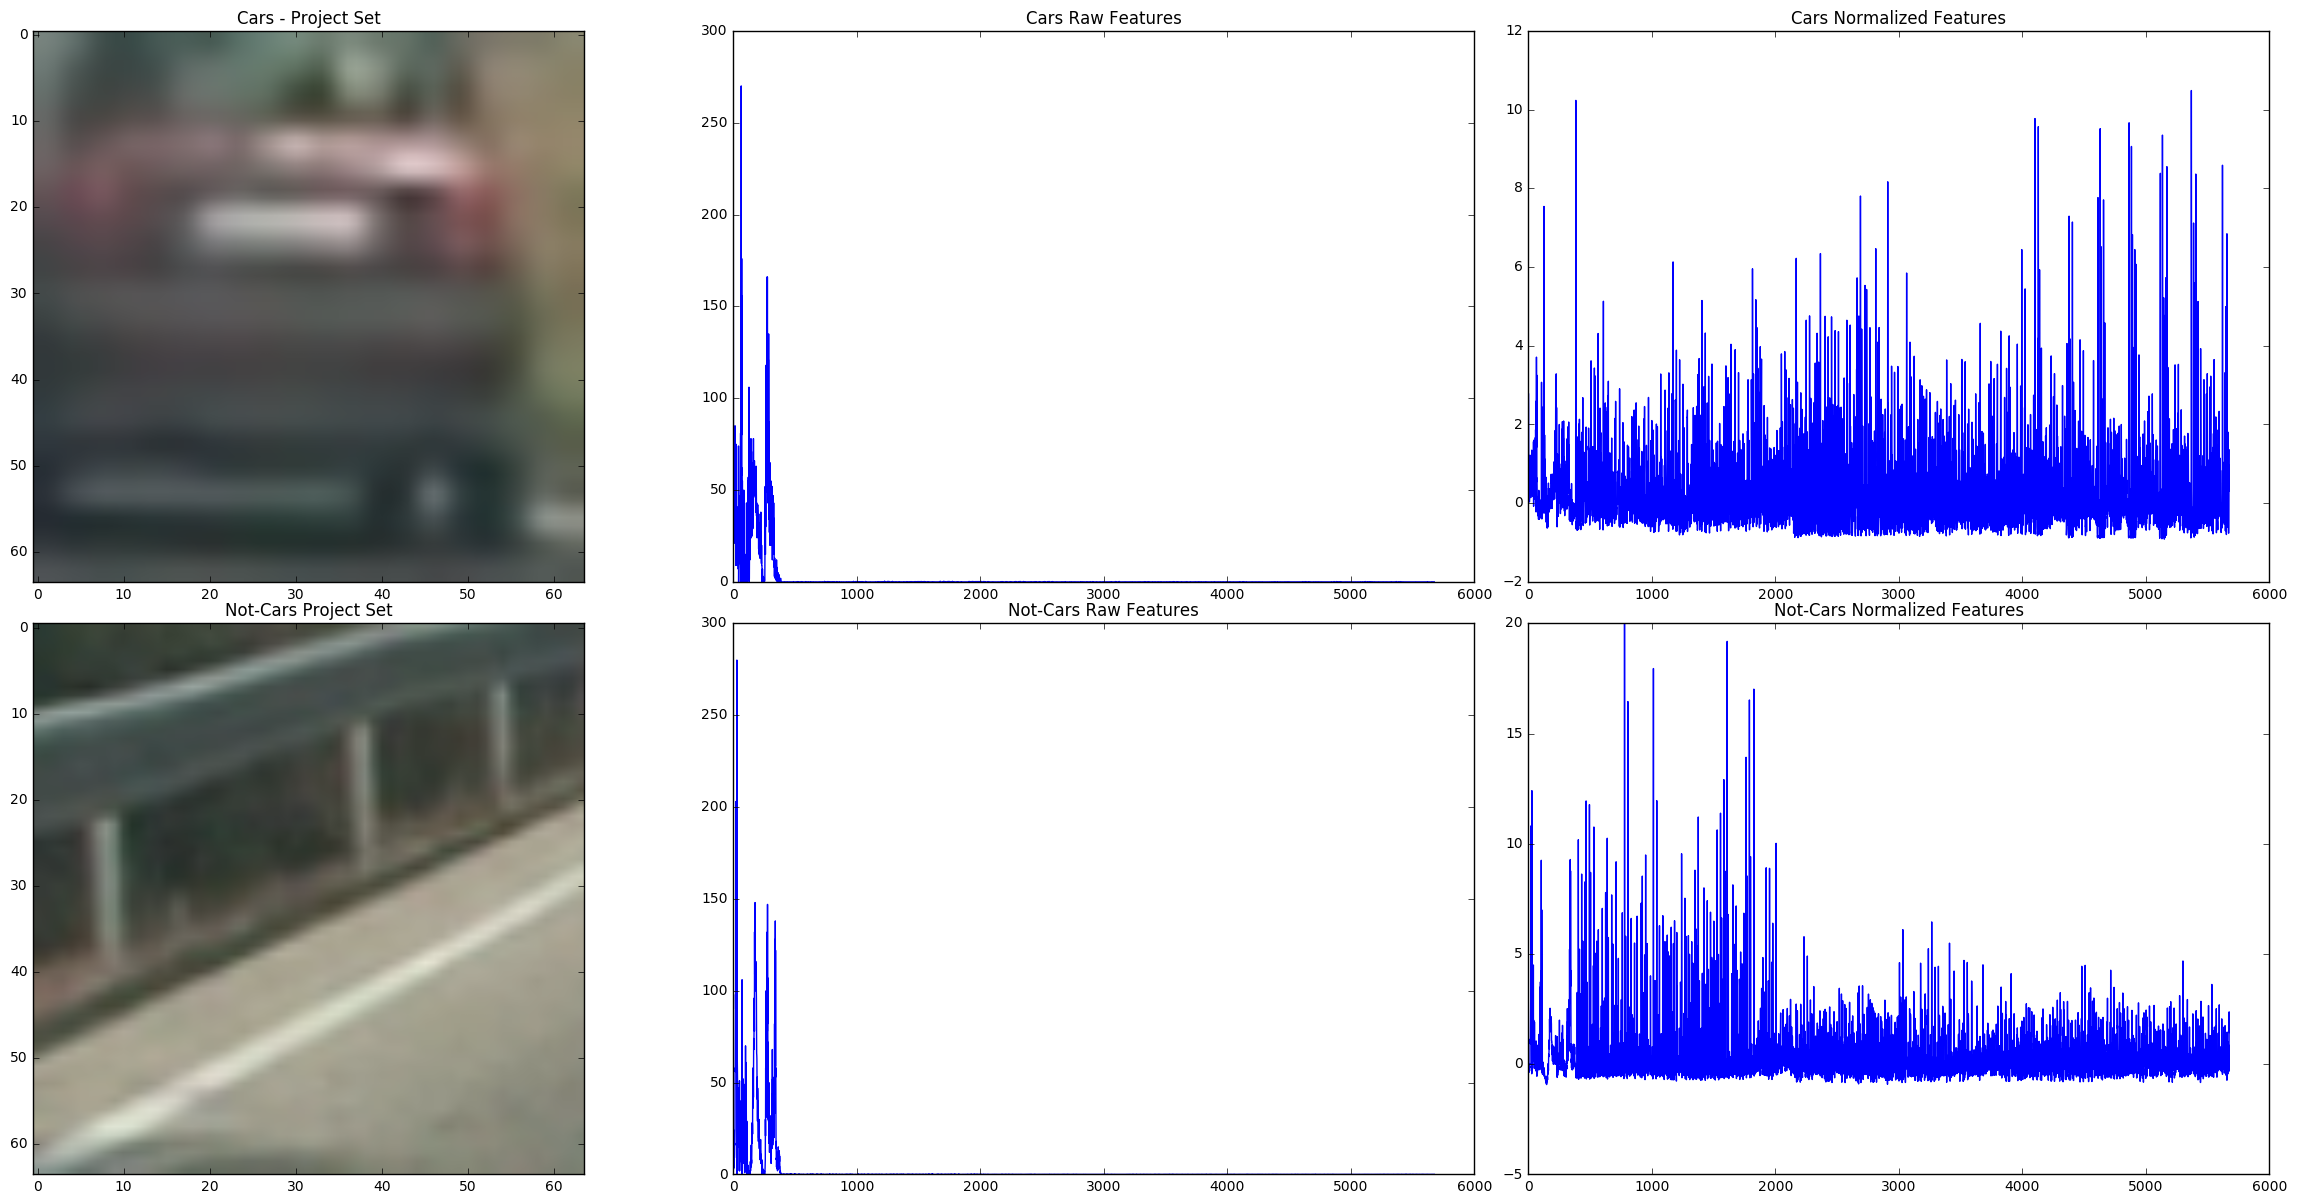

In [58]:
# Create an array stack of feature vectors
X = np.vstack((np.array(car_features), np.array(notcar_features))).astype(np.float64)

# Fit a per-column scaler
X_scaler = RobustScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
car_ind = np.random.randint(0, len(cars))

# Plot an example of raw and scaled features
fig, ((ax0, ax1, ax2),(ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(24, 12))
fig.tight_layout()

# Fill in plots of example raw and scaled features
ax0.imshow(mpimg.imread(cars[car_ind]))
ax0.set_title('Cars - Project Set')
ax1.plot(X[car_ind])
ax1.set_title('Cars Raw Features')
ax2.plot(scaled_X[car_ind])
ax2.set_title('Cars Normalized Features')

ax3.imshow(mpimg.imread(notcars[-1]))
ax3.set_title('Not-Cars Project Set')
ax4.plot(X[-1])
ax4.set_title('Not-Cars Raw Features')
ax5.plot(scaled_X[-1])
ax5.set_title('Not-Cars Normalized Features')

### Investigate HOG Features from Project Dataset

Feature Vector size for Cars: 5676
Using HOG paraameters of: 9 HOG Orientations | 8 HOG Pixels per cell | 2 HOG cells per Block and 128 histogram bins


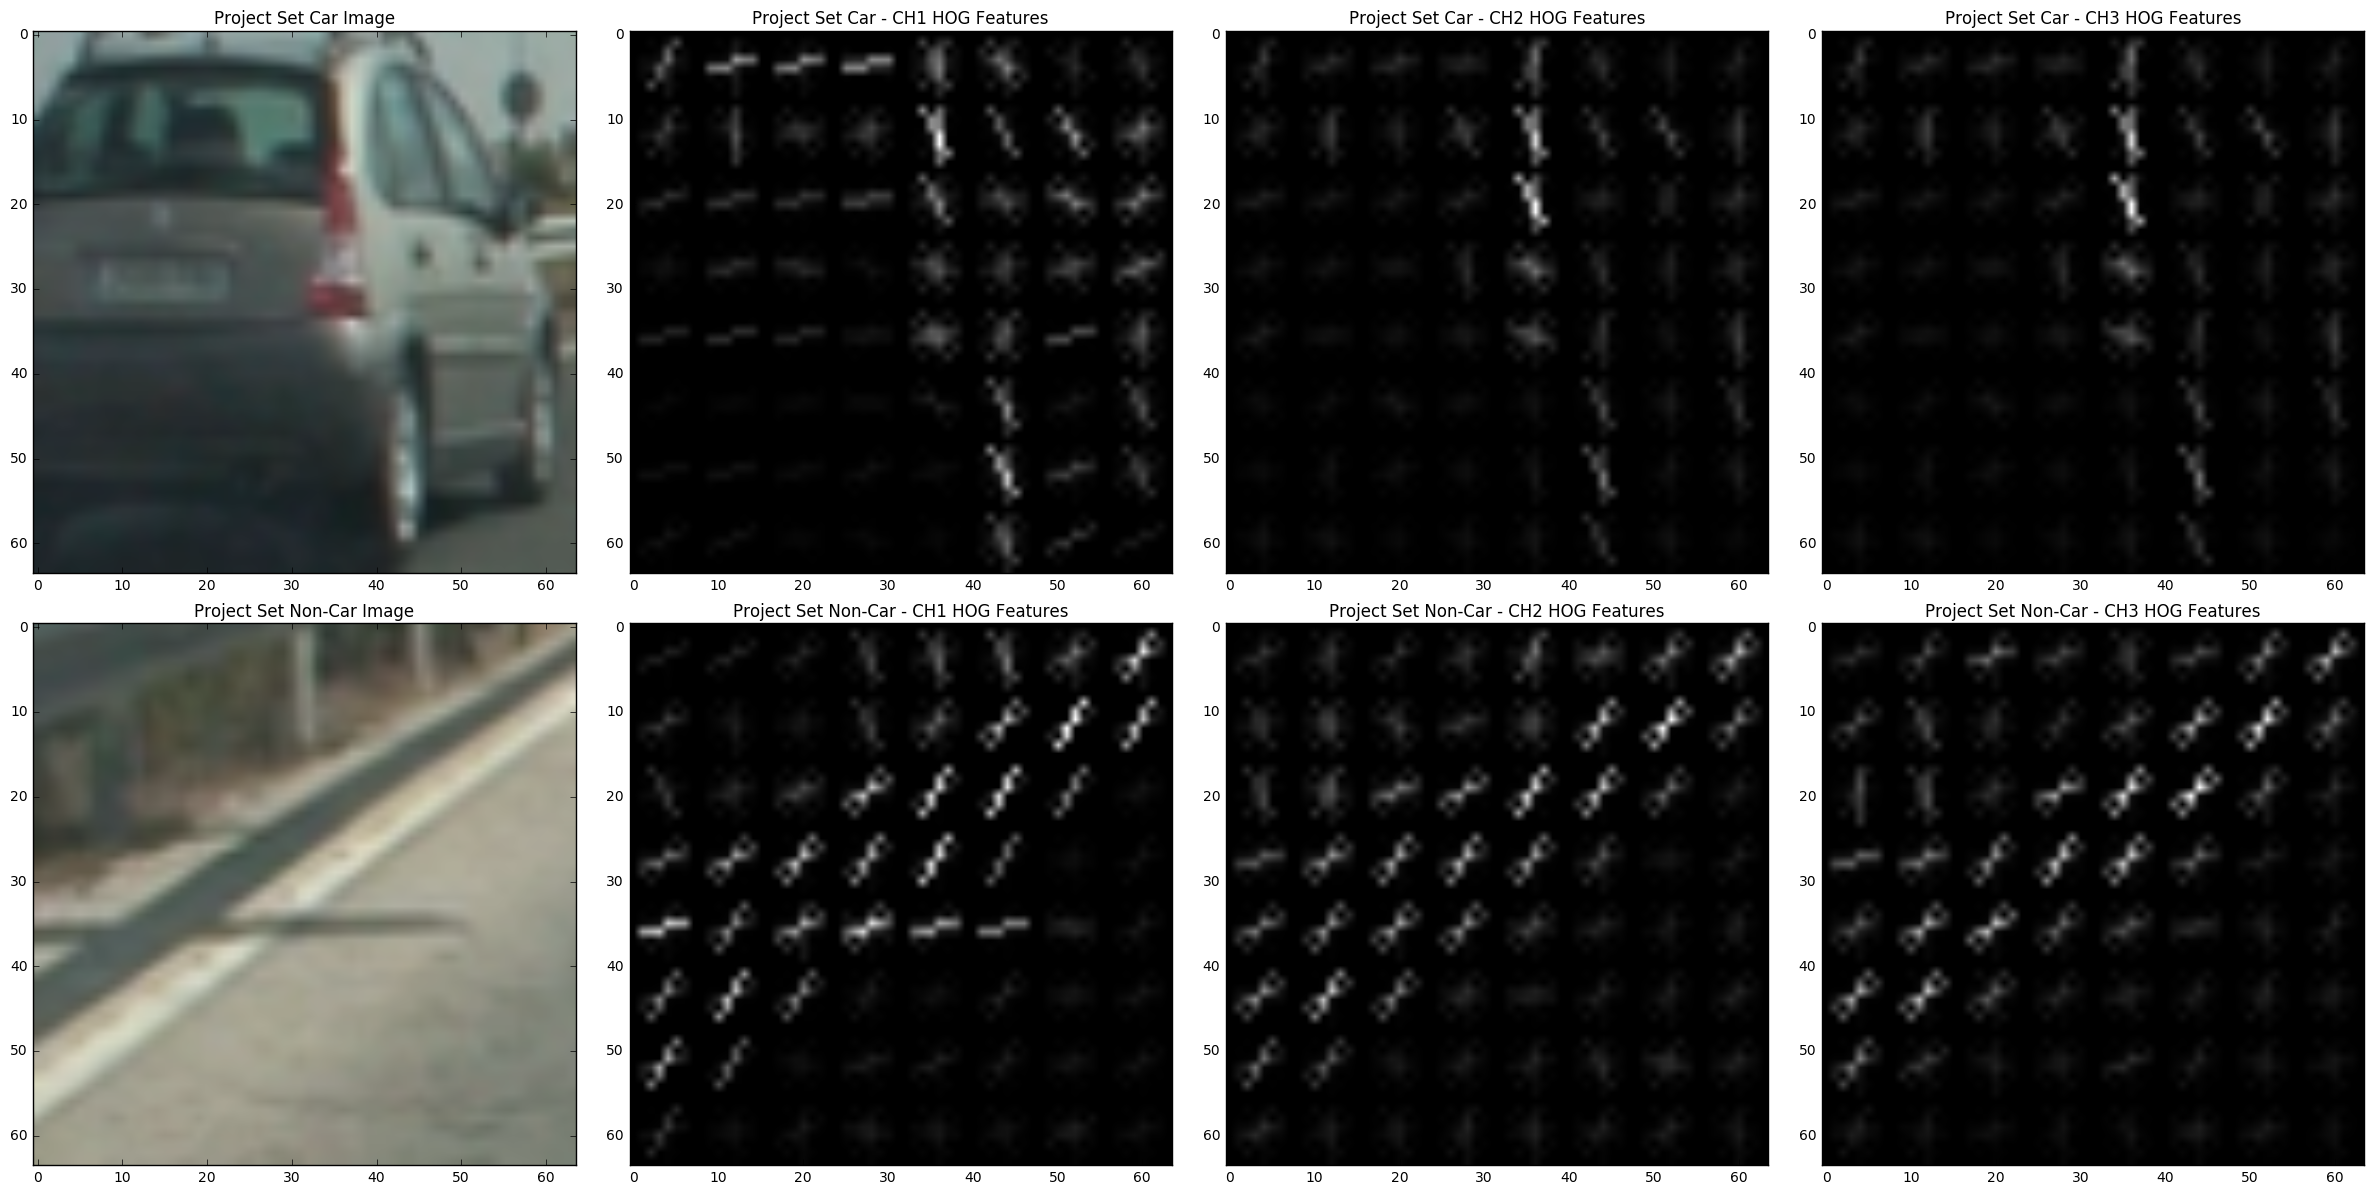

In [66]:
## Print Image from Project Set in HOG space ##
car_img = mpimg.imread(cars[car_ind])
noncar_img = mpimg.imread(notcars[-10])

car_hog_image = np.copy(cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb))
noncar_hog_image = np.copy(cv2.cvtColor(noncar_img, cv2.COLOR_RGB2YCrCb))


# Ch1
_, ch1_car_hog_image = get_hog_features(car_hog_image[:,:,0], vis=True)
_, ch1_noncar_hog_image = get_hog_features(noncar_hog_image[:,:,0], vis=True)

# Ch2
_, ch2_car_hog_image = get_hog_features(car_hog_image[:,:,1], vis=True)
_, ch2_noncar_hog_image = get_hog_features(noncar_hog_image[:,:,1], vis=True)

# Ch3
_, ch3_car_hog_image = get_hog_features(car_hog_image[:,:,1], vis=True)
_, ch3_noncar_hog_image = get_hog_features(noncar_hog_image[:,:,2], vis=True)

fig2, ((ax_6, ax_0, ax_1, ax_2),(ax_7, ax_3, ax_4, ax_5)) = plt.subplots(2, 4, figsize=(24, 12))
fig2.tight_layout()

ax_0.imshow(ch1_car_hog_image, cmap='gray')
ax_0.set_title('Project Set Car - CH1 HOG Features')

ax_1.imshow(ch2_car_hog_image, cmap='gray')
ax_1.set_title('Project Set Car - CH2 HOG Features')

ax_2.imshow(ch3_car_hog_image, cmap='gray')
ax_2.set_title('Project Set Car - CH3 HOG Features')

ax_3.imshow(ch1_noncar_hog_image, cmap='gray')
ax_3.set_title('Project Set Non-Car - CH1 HOG Features')

ax_4.imshow(ch2_noncar_hog_image, cmap='gray')
ax_4.set_title('Project Set Non-Car - CH2 HOG Features')

ax_5.imshow(ch3_noncar_hog_image, cmap='gray')
ax_5.set_title('Project Set Non-Car - CH3 HOG Features')

ax_6.imshow(car_img)
ax_6.set_title('Project Set Car Image')

ax_7.imshow(noncar_img)
ax_7.set_title('Project Set Non-Car Image')


print('Feature Vector size for Cars:', len(car_features[car_ind]))
print('Using HOG parameters of:',HOG_ORIENTATIONS, 'HOG Orientations |', HOG_PIXELS_PER_CELL, 'HOG Pixels per cell |',
HOG_CELLS_PER_BLOCK, 'HOG cells per Block',
    'and', HIST_NBINS,'histogram bins')

### Investigate HOG Features from Udacity Dataset

Feature Vector size for Cars: 5676
Using HOG parameters of: 9 HOG Orientations | 8 HOG Pixels per cell | 2 HOG cells per Block and 128 histogram bins


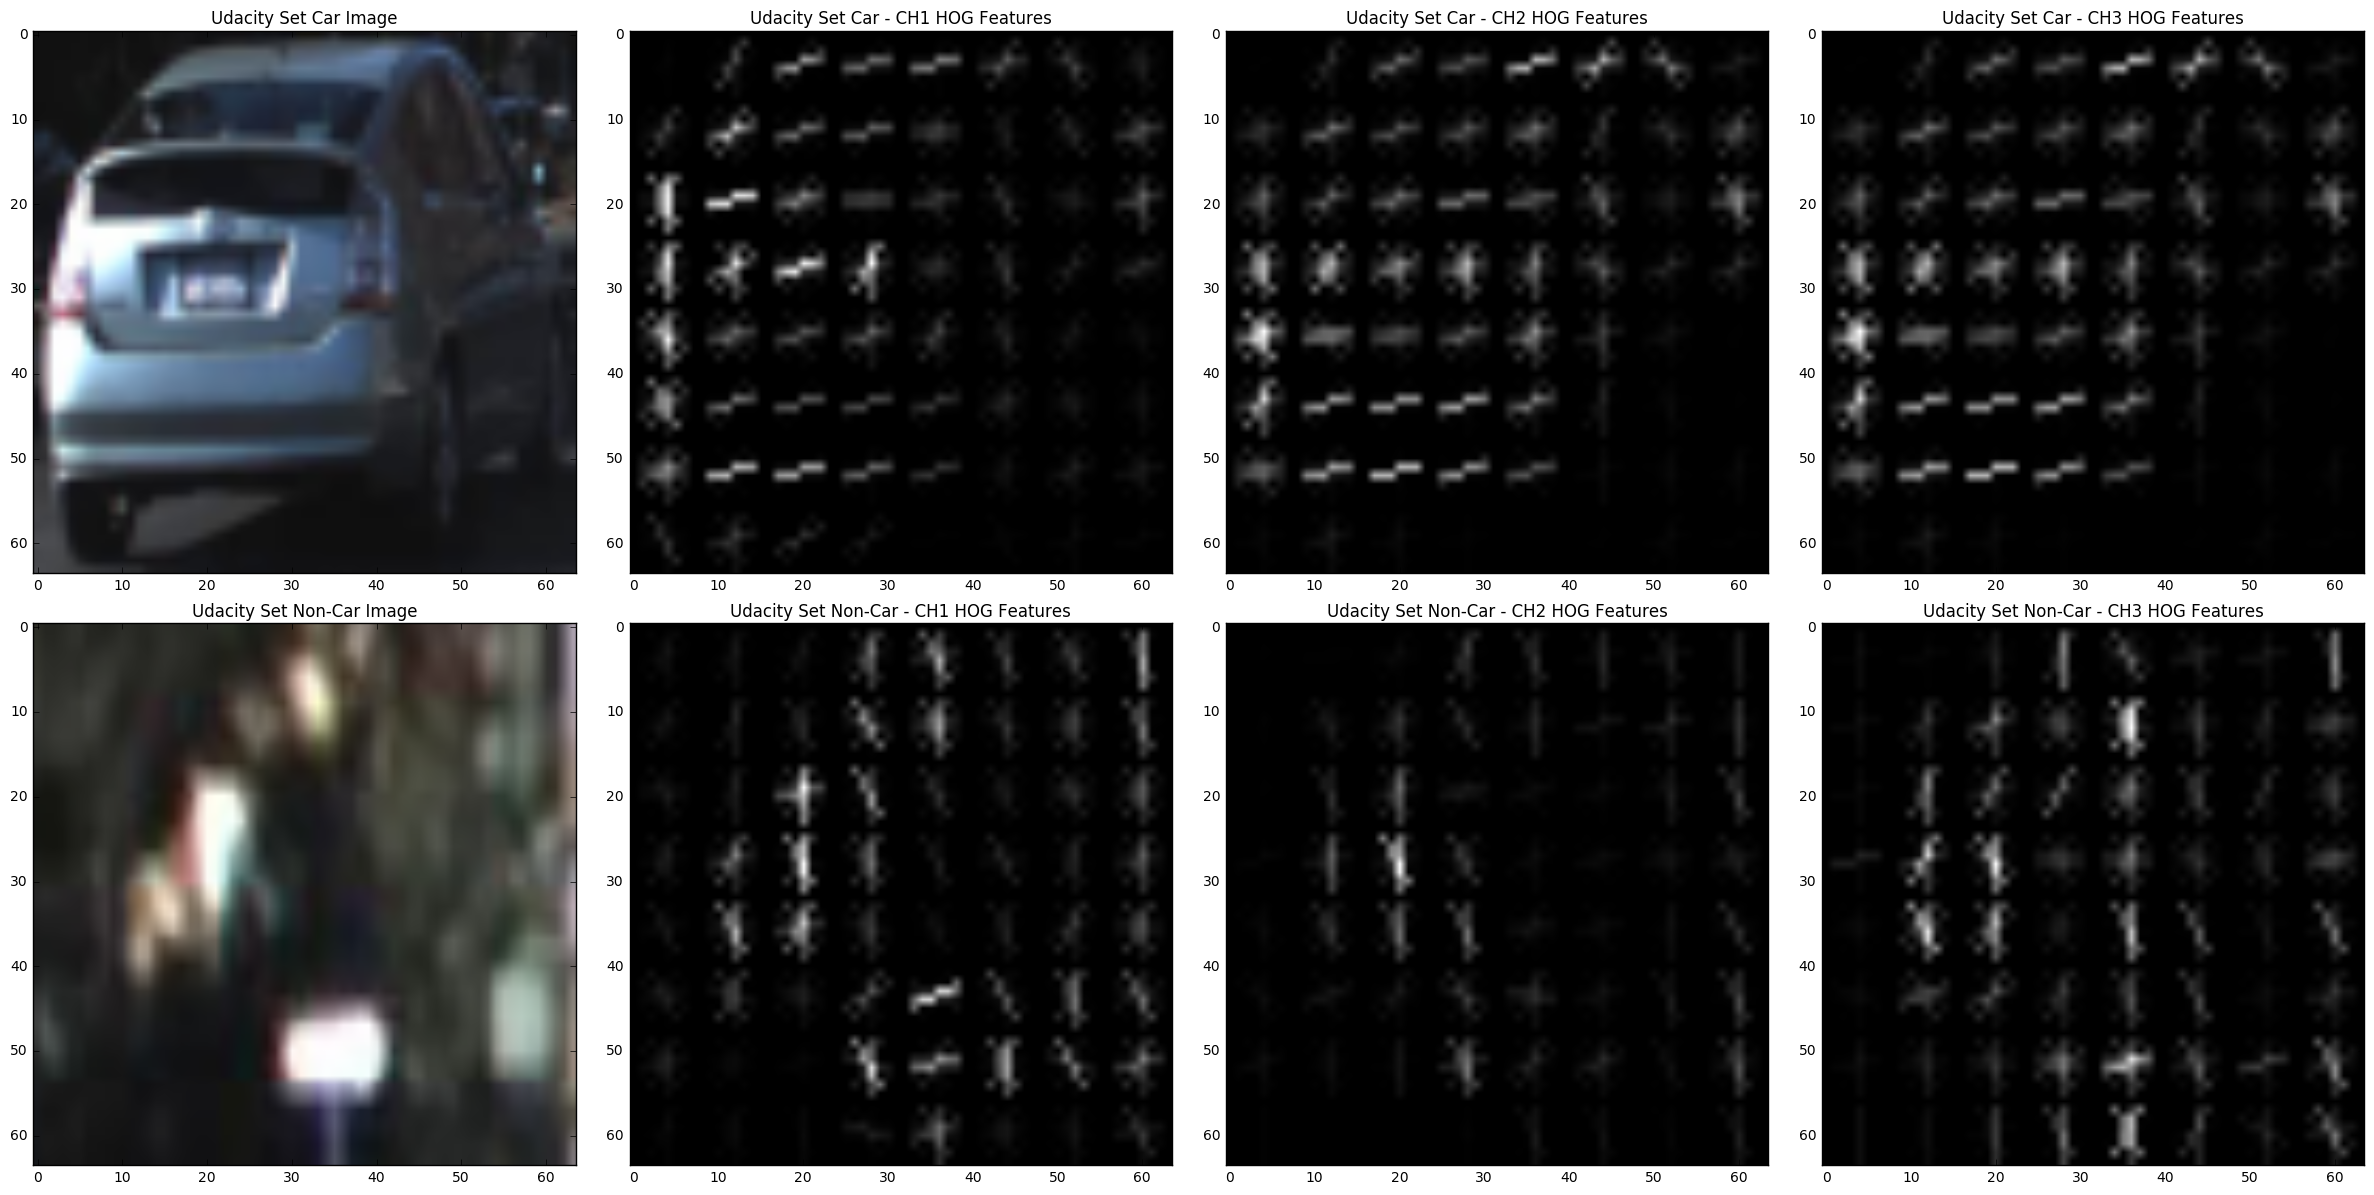

In [63]:
## Print Image from Udacity Augmented Set in HOG space ##
car_ind = np.random.randint(0, len(udacity_cars))
car_img = mpimg.imread(udacity_cars[car_ind])
noncar_img = mpimg.imread(udacity_notcars[-10])
# Convert to YCrCb for for HOG Extraction
udacity_car_hog_image = np.copy(cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb))
udacity_noncar_hog_image = np.copy(cv2.cvtColor(noncar_img, cv2.COLOR_RGB2YCrCb))


# Ch1
_, ch1_car_hog_image = get_hog_features(udacity_car_hog_image[:,:,0], vis=True)
_, ch1_noncar_hog_image = get_hog_features(udacity_noncar_hog_image[:,:,0], vis=True)

# Ch2
_, ch2_car_hog_image = get_hog_features(udacity_car_hog_image[:,:,1], vis=True)
_, ch2_noncar_hog_image = get_hog_features(udacity_noncar_hog_image[:,:,1], vis=True)

# Ch3
_, ch3_car_hog_image = get_hog_features(udacity_car_hog_image[:,:,1], vis=True)
_, ch3_noncar_hog_image = get_hog_features(udacity_noncar_hog_image[:,:,2], vis=True)

fig2, ((ax_6, ax_0, ax_1, ax_2),(ax_7, ax_3, ax_4, ax_5)) = plt.subplots(2, 4, figsize=(24, 12))
fig2.tight_layout()

ax_0.imshow(ch1_car_hog_image, cmap='gray')
ax_0.set_title('Udacity Set Car - CH1 HOG Features')

ax_1.imshow(ch2_car_hog_image, cmap='gray')
ax_1.set_title('Udacity Set Car - CH2 HOG Features')

ax_2.imshow(ch3_car_hog_image, cmap='gray')
ax_2.set_title('Udacity Set Car - CH3 HOG Features')

ax_3.imshow(ch1_noncar_hog_image, cmap='gray')
ax_3.set_title('Udacity Set Non-Car - CH1 HOG Features')

ax_4.imshow(ch2_noncar_hog_image, cmap='gray')
ax_4.set_title('Udacity Set Non-Car - CH2 HOG Features')

ax_5.imshow(ch3_noncar_hog_image, cmap='gray')
ax_5.set_title('Udacity Set Non-Car - CH3 HOG Features')

ax_6.imshow(car_img)
ax_6.set_title('Udacity Set Car Image')

ax_7.imshow(noncar_img)
ax_7.set_title('Udacity Set Non-Car Image')


print('Feature Vector size for Cars:', len(car_features[car_ind]))
print('Using HOG parameters of:',HOG_ORIENTATIONS, 'HOG Orientations |', HOG_PIXELS_PER_CELL, 'HOG Pixels per cell |',
HOG_CELLS_PER_BLOCK, 'HOG cells per Block',
    'and', HIST_NBINS,'histogram bins')

In [67]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [68]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=VALIDATION_PORTION, random_state=rand_state)
print('Feature vector length:', len(X_train[0]))

Feature vector length: 5676


### Train using  Support Vector Classifier

In [69]:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = N_PREDICTIONS
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

107.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9885
SVC predicts:  [ 1.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.
  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  1.
  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.
  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  0.  0.  0.  1.  0.
  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.]
For these 100 labels:  [ 1.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0.
  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  1.
  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.
  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  1.  0.  0.  0.  0.  1.  0.
  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.]
0.09304 Seconds to predict 100 labels with SVC


In [70]:
#Save Support Vector Classifier to Datacache
def save_to_datacache(support_vector_classifier, datacache_dir=DATACACHE_DIRECTORY, 
                      override_datacache=OVERWRITE_DATACACHE):
    os.makedirs(datacache_dir, exist_ok=True)
    svc_pickle = os.path.join(datacache_dir,"svc_pickle.p")
    if override_datacache or not os.path.exists(svc_pickle): 
        svc_hyperparameters = {'svc': svc,
                               'X_SCALER':X_scaler,
                               'SPATIAL': SPATIAL, 
                               'HIST_NBINS': HIST_NBINS,
                               'COLOR_SPACE': COLOR_SPACE,
                               'HOG_ORIENTATIONS': HOG_ORIENTATIONS,
                               'HOG_PIXELS_PER_CELL': HOG_PIXELS_PER_CELL,
                               'HOG_CELLS_PER_BLOCK': HOG_CELLS_PER_BLOCK,
                               'HOG_CHANNEL': HOG_CHANNEL,
                               'SW_SPATIAL_FEAT_FLAG': SW_SPATIAL_FEAT_FLAG,
                               'SW_HOG_FEAT_FLAG': SW_HOG_FEAT_FLAG,
                               'SW_COLOR_HIST_FEAT_FLAG': SW_COLOR_HIST_FEAT_FLAG
                              }

        pickle.dump(svc_hyperparameters, open(svc_pickle, "wb"))
    
# Save classifier and parameters to datacache directory  
save_to_datacache(svc)

# Vehicle Detection and Tracking

### Re-Initialize Imports

In [71]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import os
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

### Re-initialize Constants from Pickle File

In [117]:
## Directories ##
WORKING_DIRECTORY = 'data/'
DATACACHE_DIRECTORY = os.path.join(WORKING_DIRECTORY, 'datacache/')
svc_pickle = os.path.join(DATACACHE_DIRECTORY,"svc_pickle.p")
TESTING_DATASET_DIRECTORY = 'testing_dataset/'
TESTING_PIPELINE_SETUP_DIR= 'test_images/'
testset_path = "{}{}{}".format(WORKING_DIRECTORY, TESTING_PIPELINE_SETUP_DIR, '*.jpg')
with open(svc_pickle, mode='rb') as f:
    svc_hyperparameters = pickle.load(f)
    
## Feature Extraction Parameters ##
SVC = svc_hyperparameters['svc']
X_SCALER = svc_hyperparameters['X_SCALER']
# Spatial Binning
SW_SPATIAL_FEAT_FLAG = svc_hyperparameters['SW_SPATIAL_FEAT_FLAG'] 
SPATIAL = svc_hyperparameters['SPATIAL']
BIN_SPATIAL_SIZE = (SPATIAL, SPATIAL)
# Color Histogram
SW_COLOR_HIST_FEAT_FLAG = svc_hyperparameters['SW_COLOR_HIST_FEAT_FLAG']
HIST_NBINS = svc_hyperparameters['HIST_NBINS']
COLOR_SPACE = svc_hyperparameters['COLOR_SPACE']
# HOG Parameters
SW_HOG_FEAT_FLAG = svc_hyperparameters['SW_HOG_FEAT_FLAG']
HOG_ORIENTATIONS = svc_hyperparameters['HOG_ORIENTATIONS']
HOG_PIXELS_PER_CELL = svc_hyperparameters['HOG_PIXELS_PER_CELL']
HOG_CELLS_PER_BLOCK = svc_hyperparameters['HOG_CELLS_PER_BLOCK']
HOG_CHANNEL = svc_hyperparameters['HOG_CHANNEL']

## Sliding Windows Parameters ##
SW_XSTART_STOPS = [(200, None), (256, 1000)]
SW_YSTART_STOPS = [(384, 640), (384, None)]
SW_XY_WINDOWS = [(96,96),(128,128)]
SW_XY_OVERLAPS = [(.450,.480),(.21,.280)] 

## Parameters - HOG Sub-Sampling ##
SW_YSTART = 400
SW_YSTOP = 656
SW_SCALES = [1.0, 1.5, 1.75]
SW_CONVERT_COLOR = 'RGB2YCrCb'

## Vehicle Detection & Smoothing Parameters ##
BBOX_COLOR = (0, 255, 0)
BBOX_THICK = 5
SMOOTHING_FACTOR = 13

## Explore Detection Technique (1) - Sliding Windows 

In [73]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=BBOX_COLOR, thick=BBOX_THICK):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, (bbox[0][0], bbox[0][1]), (bbox[1][0],bbox[1][1]), color, thick)
    return imcopy

In [74]:
# Define a wrapper function for passing in a list of slidw_window parameters
def slide_windows(img, x_start_stops=[[None, None]],
                  y_start_stops=[[None, None]],
                  xy_windows=[(64, 64)],
                  xy_overlaps=[(0.5, 0.5)]):
    windows = []
    for i in range(len(x_start_stops)):
        if len(x_start_stops) == len(xy_windows) and len(x_start_stops) == len(xy_overlaps):
            windows.extend(slide_window(img, np.asarray(x_start_stops[i]), np.asarray(y_start_stops[i]),
                                np.asarray(xy_windows[i]), np.asarray(xy_overlaps[i])))
        else:
            windows.extend(slide_window(img, np.asarray(x_start_stops[i]), np.asarray(y_start_stops[i]),
                                np.asarray(xy_windows[0]), np.asarray(xy_overlaps[0])))
    return np.concatenate(windows)

In [75]:
# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions), and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None],
                 y_start_stop=[None, None], 
                 xy_window=(64, 64), 
                 xy_overlap=(0.5, 0.5)):
    window_list=[]
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None or x_start_stop[1] >= img.shape[1]:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None or y_start_stop[1] >= img.shape[0]:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)

    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append([[(startx, starty), (endx, endy)]])
    return window_list

### Visualize Method 
This method is to be used by the Debugging code cells throught the notebook. This is to make it wasier to plot lists of images

In [131]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i)
        plt.title(i)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

#### Feature Extractor Function - Single Image
This function is very similar to the `extract_features()` function noted above accept that it requires a single image to check against rather than list of images

In [83]:
def single_img_features(img, color_space=COLOR_SPACE, 
                        spatial_size=BIN_SPATIAL_SIZE,
                        hist_bins=HIST_NBINS, 
                        orient=HOG_ORIENTATIONS, 
                        pix_per_cell=HOG_PIXELS_PER_CELL, 
                        cell_per_block=HOG_CELLS_PER_BLOCK,
                        hog_channel=HOG_CHANNEL, 
                        spatial_feat=SW_SPATIAL_FEAT_FLAG,
                        hist_feat=SW_COLOR_HIST_FEAT_FLAG, 
                        hog_feat=SW_HOG_FEAT_FLAG):
    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      

    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        #img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_image = hog_image = np.copy(cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb))
        hog_shape = np.asarray(hog_image.shape)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(len(hog_shape)):
                hog_features.append(get_hog_features(hog_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        # Append the new feature vector to the features list
        # Allow for flagged setting of feature vectors (spatial, hist, hog) must maintain the ordering
        if(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
            img_features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
            img_features.append(np.concatenate((hist_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
            img_features.append(np.array(hog_features))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
            img_features.append(np.concatenate((spatial_features, hog_features)))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == False):
            img_features.append(np.array(spatial_features))
        elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
            img_features.append(np.concatenate((spatial_features, hist_features)))
        elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
            img_features.append(np.array(hist_features))
        else:
            img_features.append(np.concatenate(feature_image))
    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Search Windows Function - Key Helper Function
To implement a robust window detection algorithm, we require a function you that accepts an image as well as an arbitrary number of windows and performs a search on the windows, utilizing the SVC to predict bounding boxes for Cars. This can be a handy tool for any of the following detection techniques. In fact all 3 algortihms I perform utilizer search windows to some capacity.

In [84]:
def search_windows(img, windows, svc=SVC, 
                   X_scaler=X_SCALER, 
                   color_space=COLOR_SPACE, 
                   spatial_size=BIN_SPATIAL_SIZE, 
                   hist_bins=HIST_NBINS, 
                   orient=HOG_ORIENTATIONS, 
                   pix_per_cell=HOG_PIXELS_PER_CELL, 
                   cell_per_block=HOG_CELLS_PER_BLOCK, 
                   hog_channel=HOG_CHANNEL, 
                   spatial_feat=SW_SPATIAL_FEAT_FLAG, 
                   hist_feat=SW_COLOR_HIST_FEAT_FLAG, 
                   hog_feat=SW_HOG_FEAT_FLAG):
            
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    heatmap = np.zeros_like(img[:,:,0])    
    #2) Iterate over all windows in the list
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], 
                              (DEFAULT_LENGTH, DEFAULT_WIDTH)) 
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(list(np.array(features).reshape(1, -1)))
        #6) Predict using classifier
        prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1: # Car detected
            on_windows.append(window)
            heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] +=1

    #8) Return windows for positive detections
    return on_windows, heatmap
    

#### Select images to test Sliding Windows Implementation

In [85]:
# Try Scaling Windows on Test Images
image_paths = glob.glob(testset_path, recursive=True)
print('Found',len(image_paths),'images in directory:', testset_path)

Found 6 images in directory: data/test_images/*.jpg


In [86]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_single_frame_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for label in labels:
        for car_number in range(1, label[1] + 1):
            #Find pixels with each car_number label value
            nonzero = (label[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            #Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            #Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], BBOX_COLOR, BBOX_THICK)
        # Return the image
    return img

### Sliding Windows Visualization - (Great for Debugging)
#### Define a single function that can extract features using sliding windows and make predictions
Note: This function is essentially duplicate code from my previous slide wiindows techniques implemented throughout.

BBoxes Found: 1
1.2547149658203125 seconds to process one image search 97 windows
BBoxes Found: 0
0.8132469654083252 seconds to process one image search 97 windows
BBoxes Found: 0
1.5187509059906006 seconds to process one image search 97 windows
BBoxes Found: 1
0.9834010601043701 seconds to process one image search 97 windows
BBoxes Found: 0
0.8997938632965088 seconds to process one image search 97 windows
BBoxes Found: 1
0.6672577857971191 seconds to process one image search 97 windows


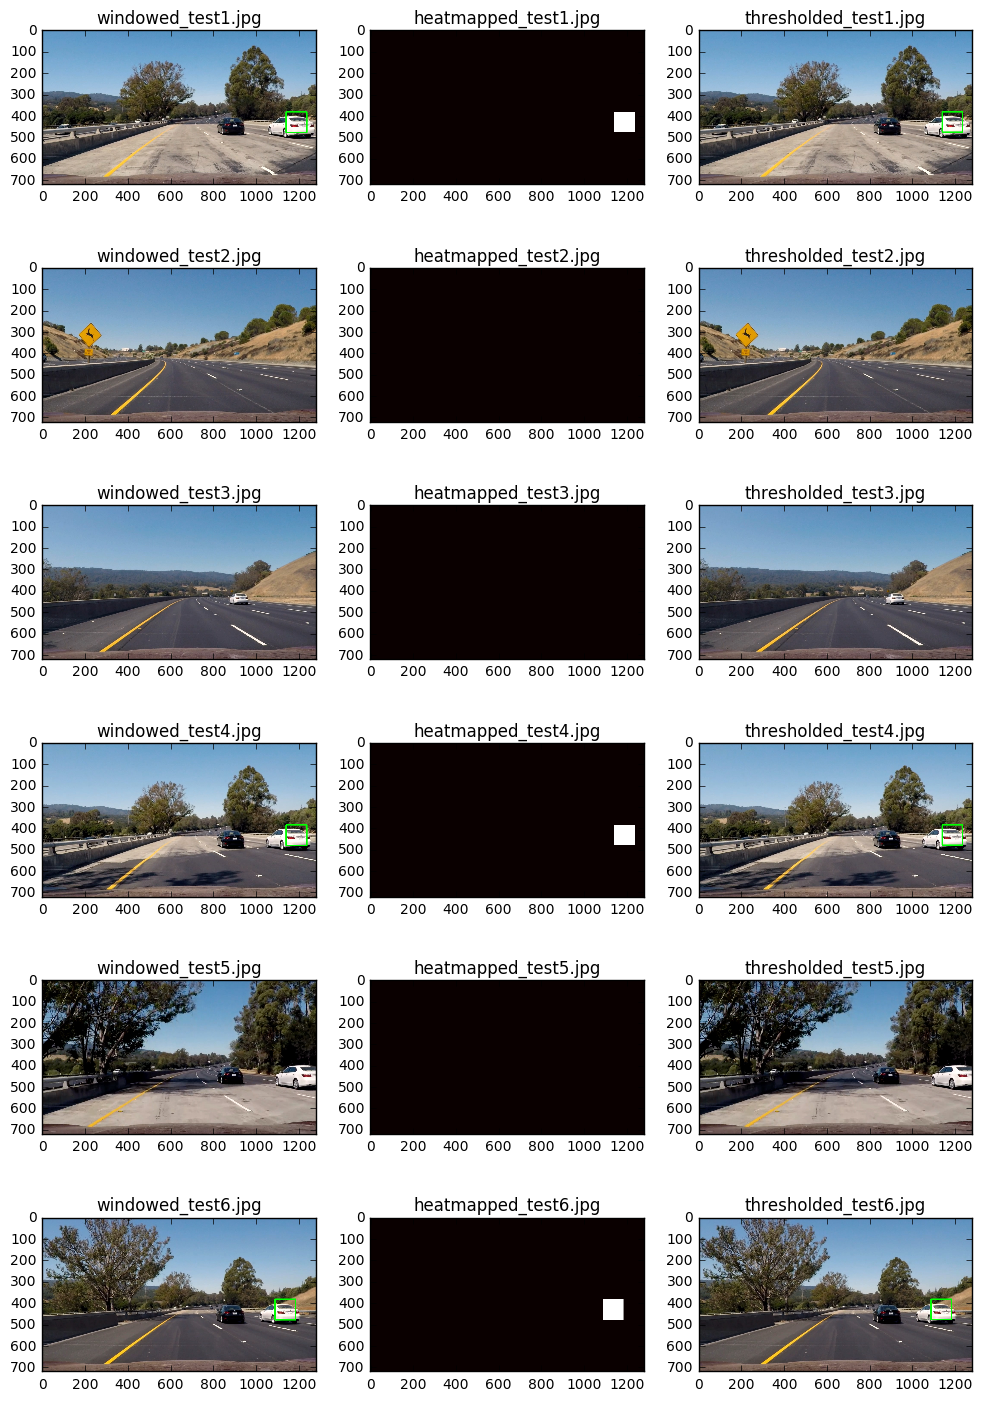

In [126]:
carslist = []
out_images = []
out_titles = []
labels = []


for img_path in image_paths:
    t1 = time.time()
    img = mpimg.imread(img_path)
    img_shape = img.shape
    img = np.copy(img)
    draw_img = np.copy(img)
    #Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    threshold = 0
    filename = os.path.split(img_path)[-1]
    denorm_img = denormalize_pixels(img)
    
    windows = slide_windows(denorm_img, x_start_stops=SW_XSTART_STOPS, 
                              y_start_stops=SW_YSTART_STOPS, 
                              xy_windows=SW_XY_WINDOWS, 
                              xy_overlaps=SW_XY_OVERLAPS)
    
    hot_windows, heatmap = search_windows(denorm_img, windows)
    print('BBoxes Found:', len(hot_windows))
    
    window_img = draw_boxes(denorm_img, hot_windows, color=BBOX_COLOR, thick=BBOX_THICK)
    labels = label(apply_threshold(heatmap, threshold))
    
    # Draw bounding boxes on a copy of the input image       
    window_img_thresh = draw_single_frame_labeled_bboxes(draw_img, [labels])

    out_images.append(window_img)
    out_titles.append('windowed_'+filename)
    out_images.append(heatmap)
    out_titles.append('heatmapped_'+filename)
    out_images.append(window_img_thresh)
    out_titles.append('thresholded_'+filename)
    
    print(time.time()-t1, 'seconds to process one image search', len(windows), 'windows')

fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 3, out_images, out_titles)

## Explore Vehicle Dectection Technique (2) - HOG Sub-Sampling Window Search 

We want a more efficient way to detect vehicles. This approach will allow for only a single call to get HOG features. The pipeline will then find a sub sample

In [119]:
def convert_color(img, conv=SW_CONVERT_COLOR):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(np.copy(img), cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(np.copy(img), cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(np.copy(img), cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(np.copy(img), cv2.COLOR_RGB2HSV)

#### Define a single function for debugging that can extract features using hog sub-sampling and make predictions
Note: This function is essentially duplicate code from my primary HOG subsampling implemented below

In [133]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

## Parameters - HOG Sub-Sampling ##
ystart = SW_YSTART
ystop = SW_YSTOP
scale = SW_SCALES
spatial_size=BIN_SPATIAL_SIZE
hist_bins=HIST_NBINS
orient=HOG_ORIENTATIONS
pix_per_cell=HOG_PIXELS_PER_CELL
cell_per_block=HOG_CELLS_PER_BLOCK
hog_channel=HOG_CHANNEL
spatial_feat=SW_SPATIAL_FEAT_FLAG
hog_feat=SW_HOG_FEAT_FLAG
hist_feat=SW_COLOR_HIST_FEAT_FLAG


#Iterate over the test images
for img_path in image_paths:
    img_boxes = []
    t1 = time.time()
    count = 0
    img = mpimg.imread(img_path)
    img = np.copy(img)
    denorm_img = denormalize_pixels(img)
    draw_img = np.copy(denorm_img)
    
    #Make a heatmap of zeros
    heatmap = np.zeros_like(denorm_img[:,:,0])
    img_to_search = denorm_img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_to_search, conv=SW_CONVERT_COLOR)
    
    if type(scale) == 'float':
        scale = [scale]

    for scle in scale:
        if scle != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scle), np.int(imshape[0]/scle)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        window = 64 # HOG_PIXELS_PER_CELL*HOG_PIXELS_PER_CELL # 8 cells and 8 pix per cell
        nblocks_per_window = (window // pix_per_cell)-1  # The // division is used for integers (for indices)
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


        for xb in range(nxsteps):
            for yb in range(nysteps):
                count += 1
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                # Extract HOG for this particular patch
                if SW_HOG_FEAT_FLAG == True: # Should always be true
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (DEFAULT_LENGTH, DEFAULT_WIDTH))

                # Get color features
                if SW_SPATIAL_FEAT_FLAG == True:
                    spatial_features = bin_spatial(subimg, size=BIN_SPATIAL_SIZE)
                if SW_COLOR_HIST_FEAT_FLAG == True:    
                    hist_features = color_hist(subimg, nbins=HIST_NBINS)


                # Append the new feature vector to the features list
                # Allow for flagged setting of feature vectors (spatial, hist, hog) must maintain the ordering
                if(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
                    test_feats = np.hstack((spatial_features, hist_features, hog_features))
                elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
                    test_feats = np.hstack((hist_features, hog_features))
                elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
                    test_feats = np.hstack((hog_features))
                elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
                    test_feats = np.hstack((spatial_features, hog_features))
                elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == False):
                    test_feats = np.hstack((spatial_features))
                elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
                    test_feats = np.hstack((spatial_features, hist_features))
                elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
                    test_feats = np.hstack((hist_features))
                else:
                    test_feats = np.hstack((np.ravel(img)))


                # Scale features and make a prediction
                test_features = X_SCALER.transform(test_feats.reshape(1, -1))
                test_prediction = SVC.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scle)
                    ytop_draw = np.int(ytop*scle)
                    win_draw = np.int(window*scle)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                                  (xbox_left+win_draw, ytop_draw+win_draw+ystart),BBOX_COLOR,6)
                    img_boxes.append(((xbox_left, ytop_draw+ystart),
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))

                    heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
            print(time.time()-t1, 'seconds to run, total windows = ', count)

        out_images.append(draw_img)
        out_titles.append(os.path.split(img_path)[-1])
        out_images.append(heatmap)
        out_titles.append(os.path.split(img_path)[-1])
        out_maps.append(heatmap)
        out_boxes.append(img_boxes)
    
fig = plt.figure(figsize=(12,36))
visualize(fig, 9, 2, out_images, out_titles)

0.46817994117736816 seconds to run, total windows =  12
0.4848928451538086 seconds to run, total windows =  24
0.4981119632720947 seconds to run, total windows =  36
0.5107078552246094 seconds to run, total windows =  48
0.5224289894104004 seconds to run, total windows =  60
0.5357389450073242 seconds to run, total windows =  72
0.548184871673584 seconds to run, total windows =  84
0.5625569820404053 seconds to run, total windows =  96
0.575469970703125 seconds to run, total windows =  108
0.5866219997406006 seconds to run, total windows =  120
0.5987248420715332 seconds to run, total windows =  132
0.6113688945770264 seconds to run, total windows =  144
0.6223509311676025 seconds to run, total windows =  156
0.6354730129241943 seconds to run, total windows =  168
0.6469888687133789 seconds to run, total windows =  180
0.6566569805145264 seconds to run, total windows =  192
0.6699750423431396 seconds to run, total windows =  204
0.6808698177337646 seconds to run, total windows =  216
0

ValueError: num must be 1 <= num <= 18, not 0

In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart=SW_YSTART,
              ystop=SW_YSTOP, 
              scale=SW_SCALES, 
              svc=SVC, 
              X_scaler=X_SCALER,
              orient=HOG_ORIENTATIONS, 
              pix_per_cell=HOG_PIXELS_PER_CELL, 
              cell_per_block=HOG_CELLS_PER_BLOCK,
              spatial_size=BIN_SPATIAL_SIZE, 
              hist_bins=HIST_NBINS,
              spatial_feat=SW_SPATIAL_FEAT_FLAG,
              hog_feat=SW_HOG_FEAT_FLAG,
              hist_feat=SW_COLOR_HIST_FEAT_FLAG):
    
    # If y start/stop positions not defined, set to image size      
    if ystart == None or ystart < 0:
        ystart = 384
    if ystop == None or ystop > img.shape[0]:
        ystop = img.shape[0]
    draw_img = np.copy(img)
    denormalized_img = denormalize_pixels(img)
    

    #Make a heatmap of zeros
    heatmap = np.zeros_like(denormalized_img[:,:,0])
    img_to_search = denormalized_img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_to_search, conv=SW_CONVERT_COLOR)
    
    # For each scale
    if type(scale) == 'float':
        scale = [scale]

    for scle in scale:
        if scle != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scle), np.int(imshape[0]/scle)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        window = 64 # 8 cells and 8 pix per cell
        nblocks_per_window = (window // pix_per_cell)-1  # The // division is used for integers (for indices)
        cells_per_step = 1 # HOG_CELLS_PER_BLOCK  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step # The // division is used for integers (for indices)

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                # Extract HOG for this particular patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (DEFAULT_LENGTH, DEFAULT_WIDTH))

                # Get color features
                if SW_SPATIAL_FEAT_FLAG == True:
                    spatial_features = bin_spatial(subimg, size=BIN_SPATIAL_SIZE)
                if SW_COLOR_HIST_FEAT_FLAG == True:    
                    hist_features = color_hist(subimg, nbins=HIST_NBINS)


                # Append the new feature vector to the features list
                # Allow for flagged setting of feature vectors (spatial, hist, hog) must maintain the ordering
                if(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
                    test_feats = np.hstack((spatial_features, hist_features, hog_features))
                elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == True):
                    test_feats = np.hstack((hist_features, hog_features))
                elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
                    test_feats = np.hstack((hog_features))
                elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == True):
                    test_feats = np.hstack((spatial_features, hog_features))
                elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == False and SW_HOG_FEAT_FLAG == False):
                    test_feats = np.hstack((spatial_features))
                elif(SW_SPATIAL_FEAT_FLAG == True and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
                    test_feats = np.hstack((spatial_features, hist_features))
                elif(SW_SPATIAL_FEAT_FLAG == False and SW_COLOR_HIST_FEAT_FLAG == True and SW_HOG_FEAT_FLAG == False):
                    test_feats = np.hstack((hist_features))
                else:
                    test_feats = np.hstack((np.ravel(img)))

                # Scale features and make a prediction
                test_features = X_scaler.transform(test_feats.reshape(1, -1))
                test_prediction = svc.predict(test_features)


                ## Check against classifier ## 
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scle)
                    ytop_draw = np.int(ytop*scle)
                    win_draw = np.int(window*scle)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                                  (xbox_left+win_draw, ytop_draw+win_draw+ystart),BBOX_COLOR,BBOX_THICK)
                    heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
    return draw_img, heatmap

In [ ]:
# DEFINE A CLASS TO RECEIVE THE CHARACTERISTICS OF EACH VEHICLE DETECTION
# Objects defined as "Vehicles" will be where multiple overlaping detections exists in the heatmap
class Vehicle():
    def __init__(self, bbox):
        car_lens = [car.car_number for car in carslist]
        if len(car_lens) > 0: 
            self.car_number = np.max(car_lens) + 1
        else: self.car_number = 0
        self.prev_detected = False # Flag sets if the Vehicle was detected in the last iteration
        self.cur_detected = True # Flag sets if the Vehicle is detected in the current iteration
        self.n_detections = 1 # number of times this vehicle has been detected
        self.n_non_detections = 0 # number of consecutive times this vehicle has not been detected
        self.xpixels = np.arange(bbox[0][0], bbox[1][0]+1) # Pixel x values of last detection
        self.ypixels = np.arange(bbox[0][1], bbox[1][1]+1) # Pixel y values of last detection
        self.recent_xfitted = []
        self.recent_xfitted.append(bbox[0][0]) # x position of the last n fits of the bounding box
        self.bestx = bbox[0][0] # X position of the current fit
        self.recent_yfitted = []
        self.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
        self.besty = bbox[0][1] # Average y position of the current fit
        self.recent_wfitted = []
        self.recent_wfitted.append(bbox[1][0])
        self.bestw = bbox[1][0] # Average width of the last n fits
        self.recent_hfitted = []
        self.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
        self.besth = bbox[1][1] # Average height of the last n fits
        self.bounding_box = bbox


In [ ]:
# Define a function that Implements Smoothing Factor for Multi-Fram Object Tracking
def draw_multi_frame_labeled_bboxes(img, labels, smoothing_factor=1, keep_weight=15, remove_threshold = 15, debug=False):
    noisy_pix_thresh= 4e2
    img = np.copy(img)
    # Set all cur_detected values to false for current frame
    for car in carslist:
        car.cur_detected = False
    
    for label in labels:
        # Iterate through all detected labels
        for car_number in range(1, label[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (label[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

            # Check if bounding box appears in carslist
            found_match = False
            for car in carslist:               
                # Create comparison matrix
                bbox_flatten = []
                bbox_flatten.append(bbox[0])
                bbox_flatten.append(bbox[1])
                bbox_flatten = [x for xs in bbox_flatten for x in xs]
                
                car_bbox_flat = []
                car_bbox_flat.append(car.bounding_box[0])
                car_bbox_flat.append(car.bounding_box[1])
                car_bbox_flat = [x for xs in car_bbox_flat for x in xs]
                
                if(np.allclose(bbox_flatten, car_bbox_flat, atol=13)):
                    found_match = True
                    if debug:
                        print('Found a match. Car Bounding Box', car.bounding_box, '| length nonzerox:',len(nonzerox),
                             '| length nonzeroy:',len(nonzeroy))
                        print('Checked against Bounding box:',bbox)

                    car.n_detections += 1                
                    car.prev_detected = found_match
                    car.cur_detected = found_match
                    car.n_non_detections = 0 # Reset non_detections value
                    car.xpixels = nonzerox # Pixel x values of current detection
                    car.ypixels = nonzeroy # Pixel y values of current detection
                   
                    car.recent_xfitted.append(bbox[0][0])
                    car.bestx = int(np.mean(car.recent_xfitted)*.25 + bbox[0][0]*.75) # Average x position of the last n fits
                    car.recent_yfitted.append(bbox[0][1]) # Y position of the last n fits of the bounding box
                    car.besty = int(np.mean(car.recent_yfitted)*.25 + bbox[0][1]*.75) # Average y position of the current fit
                    car.recent_wfitted.append(bbox[1][0])
                    car.bestw = int(np.mean(car.recent_wfitted)*.25 + bbox[1][0]*.75) # Average width+xstart of the last n fits
                    car.recent_hfitted.append(bbox[1][1]) # Height of the last n fits of the bounding box
                    car.besth = int(np.mean(car.recent_hfitted)*.25 + bbox[1][1]*.75) # Average height+ystart of the last n fits

                    car.bounding_box = ((car.bestx, car.besty),
                                            (car.bestw, car.besth))
                    break

            # After searching for existing car, add new Vehicle         
            if found_match == False and len(nonzerox) > noisy_pix_thresh and len(nonzeroy) < 1e5: 
                # Add New Vehicle
                car = Vehicle(bbox)
                car.xpixels = nonzerox
                car.ypixels = nonzeroy
                car.n_non_detections +=1
                car.prev_detected = found_match
                car.cur_detected = True

                # Add car to carslist
                carslist.append(car)
            
        
    # After searching through labels and updating carslist, draw labels
    for car in carslist:
        ## Remove Stale cars ##
        car_lens = [car.car_number for car in carslist]
        if len(car_lens) > 0: 
            max_car_number = np.max(car_lens)
            min_car_number = np.min(car_lens)
        else: 
            max_car_number = 1
            min_car_number = 0
        if (car.n_non_detections >= remove_threshold \
            or len(car.xpixels) < noisy_pix_thresh
            or (np.abs(max_car_number - car.car_number) > keep_weight and \
                car.cur_detected == False and car.prev_detected == False) and 
                car.n_non_detections > 3):
            if debug: 
                print('Removing Car:', car.bounding_box)
                print('Carlist now has size:', len(carslist))
            carslist.remove(car)
            
        # Set n_non_detections+=1 for each car in carslist that wasn't prev_detected
        if (car.prev_detected == True and car.cur_detected == False):
            if debug:
                print('Found possible false positive for car:', car.bounding_box, 'checking against smoothing factor')
                print( 'Car number:', car.car_number)
            car.prev_detected == False
            car.n_non_detections +=1
        
        ## Apply noise filtering to object detections
        #Process cars within the smoothing factor range
        if (car.n_detections >= smoothing_factor//2 \
            and car.n_detections > car.n_non_detections #prev had this as an or
            and len(car.xpixels) > noisy_pix_thresh
            and len(car.ypixels) < 1e5):
            cv2.rectangle(img, car.bounding_box[0], car.bounding_box[1], BBOX_COLOR, BBOX_THICK)
            

            
    # Return the image
    return img

In [ ]:
# Calibration Constants #
IMAGE_EXTENSION = '.jpg'
CALIBRATION_DIRECTORY = 'camera_cal/'
CALIBRATION_PREFIX = 'corners_found'
calibration_path = "{}{}{}".format(DATACACHE_DIRECTORY, CALIBRATION_DIRECTORY, '*'+IMAGE_EXTENSION)
dist_pickle_file = os.path.join(DATACACHE_DIRECTORY, "calibration_pickle.p")
CHESSBOARD_SIZE = (9,6)

### Camera Calibration

In [97]:
# Calibrate the camera using a 9x6 checkerboard
objp = np.zeros((CHESSBOARD_SIZE[1]*CHESSBOARD_SIZE[0], 3), np.float32)
objp[:,:2] = np.mgrid[0:CHESSBOARD_SIZE[0], 0:CHESSBOARD_SIZE[1]].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3-Dim points in real-world space
imgpoints = [] # 2-Dim points in virtual image plane

# Load Calibration Images 
calibration_images = glob.glob(calibration_path, recursive=True)

# Walk through images and search for checkerboard corners
for idx, fname in enumerate(calibration_images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find the checkerboard corners
    ret, corners = cv2.findChessboardCorners(gray, CHESSBOARD_SIZE, None)
    
    # If found, add object points, image points
    if ret == True:
        print('Calibrating image:', fname)
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display found corners
        cv2.drawChessboardCorners(img, CHESSBOARD_SIZE, corners, ret)
        output_img_path = "{}{}{}{}{}".format(DATACACHE_DIRECTORY, CALIBRATION_DIRECTORY, CALIBRATION_PREFIX
                                              ,str(idx), IMAGE_EXTENSION)
        print('Saving Calibrated image:', output_img_path)

        os.makedirs(os.path.join(DATACACHE_DIRECTORY, CALIBRATION_DIRECTORY), exist_ok=True)    
        cv2.imwrite(output_img_path, img)

Calibrating image: data/datacache/camera_cal/calibration10.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found1.jpg
Calibrating image: data/datacache/camera_cal/calibration11.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found2.jpg
Calibrating image: data/datacache/camera_cal/calibration12.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found3.jpg
Calibrating image: data/datacache/camera_cal/calibration13.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found4.jpg
Calibrating image: data/datacache/camera_cal/calibration14.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found5.jpg
Calibrating image: data/datacache/camera_cal/calibration15.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found6.jpg
Calibrating image: data/datacache/camera_cal/calibration16.jpg
Saving Calibrated image: data/datacache/camera_cal/corners_found7.jpg
Calibrating image: data/datacache/camera_cal/calibration17.jpg
Saving

In [98]:
# Load image for reference
if os.path.exists(dist_pickle_file):
    dist_pickle = pickle.load( open(dist_pickle_file, "rb"))
else:
    dist_pickle = {}

img = cv2.imread(calibration_images[1])
img_size = (img.shape[1], img.shape[0])

# Perform calibration given object points and image points
if ("mtx" in dist_pickle and "dist" in dist_pickle):
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
else:
    ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save camera calibration result data
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist

pickle.dump(dist_pickle, open(dist_pickle_file, "wb"))

In [99]:
# Read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open(dist_pickle_file, "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [122]:
def process_image(img):
    if (img is not None):
        labels = []
        carslist = []
        bboxes = []
        SMOOTHING_FACTOR = 30
                
        if (len(CARS_PREV_FRAMES) > SMOOTHING_FACTOR):
            flattened_carslist = np.ravel(lambda x,y:  x+y, CARS_PREV_FRAMES[:-SMOOTHING_FACTOR]) 
            CARS_PREV_FRAMES.remove(CARS_PREV_FRAMES[0])
        else:
            flattened_carslist = np.ravel(lambda x,y:  x+y, CARS_PREV_FRAMES)

        
        # Search for cars from previous frame Gather previous bboxes from carslist
        heatmap_1 = np.zeros_like(img[:,:,2])
        heatmap_2 = np.zeros_like(img[:,:,2])
        heatmap_3 = np.zeros_like(img[:,:,2])
        img = cv2.undistort(img, mtx, dist, None, mtx)
                
        ## Search for previously detected cars in current frame ##
        for car_ind in range(0, len(flattened_carslist)-1):
            if flattened_carslist[car_ind].n_non_detections == 0:
                bboxes.append(list(flattened_carslist[car_ind].bounding_box)) # Grab previous frames for feedback loop
            
        detected_cars_threshold = SMOOTHING_FACTOR # Divide by two to account for error
        _, heatmap_1 = search_windows(img, bboxes)
        labels.append(label(apply_threshold(heatmap_1, detected_cars_threshold)))
        
        ## Detect with HOG subsampling ##
        hog_subsampling_threshold = 3
        _, heatmap_2 = find_cars(img, ystart=SW_YSTART, ystop=SW_YSTOP, scale=SW_SCALES)
        labels.append(label(apply_threshold(heatmap_2, hog_subsampling_threshold)))
        
        ## Detect with Sliding Windows ##
        sliding_windows_threshold = 4
        windows = slide_windows(img, x_start_stops=SW_XSTART_STOPS, 
                              y_start_stops=SW_YSTART_STOPS, 
                              xy_windows=SW_XY_WINDOWS, 
                              xy_overlaps=SW_XY_OVERLAPS)
        _, heatmap_3 = search_windows(img, windows)
        labels.append(label(apply_threshold(heatmap_3, sliding_windows_threshold)))
        
        combined_threshold = 1
        combined_heatmap = cv2.add(heatmap_1, heatmap_2, heatmap_3)
        labels.append(label(apply_threshold(combined_heatmap, combined_threshold)))
        draw_img = draw_multi_frame_labeled_bboxes(img, labels, smoothing_factor=SMOOTHING_FACTOR, debug=False)
        CARS_PREV_FRAMES.append(carslist)
        return draw_img
    else:
        return img

In [123]:
#Import packages to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_ouput = 'test_output.mp4'
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, test_ouput)

TEST_VIDEO = 'test_video.mp4'
VIDEO_FILE_PATH = os.path.join(WORKING_DIRECTORY, TEST_VIDEO)
clip = VideoFileClip(VIDEO_FILE_PATH)
CARS_PREV_FRAMES = []
test_clip = clip.fl_image(process_image)
#%time
test_clip.write_videofile(VIDEO_OUTPUT_PATH, audio=False)
clip = VideoFileClip(VIDEO_FILE_PATH)
CARS_PREV_FRAMES = None

HTML("""
<video width="960" height="540" controls>
 <source src="{0}">
</video>
""".format(VIDEO_OUTPUT_PATH))

[MoviePy] >>>> Building video data/test_output.mp4
[MoviePy] Writing video data/test_output.mp4



 97%|█████████▋| 38/39 [05:02<00:07,  7.75s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: data/test_output.mp4 



### Process Project Video

In [124]:
project_ouput = 'project_output_no_yolo.mp4'
PROJECT_VIDEO = 'project_video.mp4'
VIDEO_FILE_PATH = os.path.join(WORKING_DIRECTORY, PROJECT_VIDEO)
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, project_ouput)

CARS_PREV_FRAMES = []
clip = VideoFileClip(VIDEO_FILE_PATH)
project_clip = clip.fl_image(process_image)
project_clip.write_videofile(VIDEO_OUTPUT_PATH, audio=False)
CARS_PREV_FRAMES = None

[MoviePy] >>>> Building video data/project_output_no_yolo.mp4
[MoviePy] Writing video data/project_output_no_yolo.mp4


100%|█████████▉| 1260/1261 [2:57:09<00:08,  8.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: data/project_output_no_yolo.mp4 



In [125]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(VIDEO_OUTPUT_PATH))

### Implement Vehicle Detections Using [YOLO Feature Extractor](https://github.com/pjreddie/darknet/blob/master/src/yolo.c):

At this point, I feel as if I have exhausted all options, as such I now will utilize the new and improved YOLO library to perform feature extraction. 

This is ideal because my ultimate goal is to provide real-time detection and the sliding windows is at best 3-4 seconds per frame.

In [113]:
def process_yolo(frame, output_extension='.jpg'):
    global COUNTER
    # Increment Counter
    COUNTER += 1
        
    if frame is not None:
        frame = cv2.cvtColor(np.copy(frame), cv2.COLOR_BGR2RGB)
        ## process image using Yolo libraries ##
        ## Create directory for prediction input ##
        YOLO_INPUT_DIR = 'darkflow/test/process/'
        YOLO_CACHE_DIR =os.path.join(DATACACHE_DIRECTORY,YOLO_INPUT_DIR) # DATACACHE_DIRECTORY = data/datacache/
        
        ## YOLO's processed directory ##
        outfile = os.path.join(YOLO_INPUT_DIR, 'out/')
        os.makedirs(outfile, exist_ok=True)
        im = Image.fromarray(frame)
        im.save(YOLO_INPUT_DIR+'yolo_file_'+str(COUNTER)+output_extension)
        
        # Save to cache
        im_copy = Image.fromarray(frame)
        im_copy.save(YOLO_CACHE_DIR+'yolo_file_'+str(COUNTER)+output_extension)
        
        ## Predict ##
        !source activate sdc_dev && cd darkflow && ./flow --test test/process --model cfg/tiny-yolo.cfg
        #!source activate sdc_dev && cd darkflow && ./flow --test test/process --model cfg/tiny-yolo.cfg --load bin/tiny-yolo.weights

        prediction = glob.glob(outfile+'*.jpg')
        if len(prediction) > 0:
            copy_img = cv2.imread(prediction[0])
        else:
            copy_img = frame
            
        shutil.rmtree(outfile)
        
        # Return prediction
        return copy_img
    else:
        return frame

In [116]:
from PIL import Image
import shutil
import os

project_ouput = 'project_output_yolo.mp4'
PROJECT_VIDEO = 'project_video.mp4'
output_dir = 'output_images/'
COUNTER = 0
VIDEO_FILE_PATH = os.path.join(WORKING_DIRECTORY, PROJECT_VIDEO)
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, output_dir, project_ouput)
os.makedirs(os.path.join(WORKING_DIRECTORY, output_dir), exist_ok=True)

# Make Datacache Directory
os.makedirs(os.path.join(DATACACHE_DIRECTORY,'darkflow/test/process/'), exist_ok=True)

clip = VideoFileClip(VIDEO_FILE_PATH)

# Process a test bed
project_clip = clip.fl_image(process_yolo).subclip(26,35)
project_clip.write_videofile(VIDEO_OUTPUT_PATH, audio=False)

HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(VIDEO_OUTPUT_PATH))

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00013899803161621094s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  0%|          | 0/226 [00:00<?, ?it/s]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00018215179443359375s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  0%|          | 1/226 [00:18<1:07:43, 18.06s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00014019012451171875s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  1%|          | 2/226 [00:40<1:12:16, 19.36s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001990795135498047s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


  1%|▏         | 3/226 [01:06<1:19:02, 21.27s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0004780292510986328s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


  2%|▏         | 4/226 [01:50<1:44:30, 28.25s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00012302398681640625s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  2%|▏         | 5/226 [02:20<1:45:28, 28.63s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001609325408935547s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


  3%|▎         | 6/226 [02:51<1:47:48, 29.40s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001430511474609375s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


  3%|▎         | 7/226 [03:23<1:49:49, 30.09s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0002288818359375s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 256)



  4%|▎         | 8/226 [03:50<1:46:04, 29.20s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00015401840209960938s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  4%|▍         | 9/226 [04:17<1:43:33, 28.63s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00013494491577148438s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  4%|▍         | 10/226 [04:45<1:41:54, 28.31s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00014400482177734375s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  5%|▍         | 11/226 [05:13<1:41:53, 28.44s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00015497207641601562s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  5%|▌         | 12/226 [05:43<1:42:48, 28.83s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00014710426330566406s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  6%|▌         | 13/226 [06:13<1:43:36, 29.19s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00011777877807617188s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  6%|▌         | 14/226 [06:46<1:47:13, 30.35s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00016117095947265625s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  7%|▋         | 15/226 [07:21<1:51:13, 31.63s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 9.894371032714844e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


  7%|▋         | 16/226 [07:53<1:51:41, 31.91s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001659393310546875s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


  8%|▊         | 17/226 [08:27<1:52:53, 32.41s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00012993812561035156s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  8%|▊         | 18/226 [09:04<1:56:47, 33.69s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00011110305786132812s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  8%|▊         | 19/226 [09:39<1:57:50, 34.15s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00015282630920410156s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


  9%|▉         | 20/226 [10:20<2:04:15, 36.19s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 9.799003601074219e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


  9%|▉         | 21/226 [10:58<2:05:19, 36.68s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 9.894371032714844e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 10%|▉         | 22/226 [11:33<2:03:20, 36.28s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00014400482177734375s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 10%|█         | 23/226 [12:14<2:07:17, 37.62s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00010704994201660156s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 11%|█         | 24/226 [12:59<2:14:05, 39.83s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00015592575073242188s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 11%|█         | 25/226 [13:43<2:17:27, 41.03s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00011587142944335938s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 12%|█▏        | 26/226 [14:27<2:19:54, 41.97s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00011086463928222656s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 12%|█▏        | 27/226 [15:08<2:18:18, 41.70s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00010395050048828125s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 12%|█▏        | 28/226 [15:50<2:18:16, 41.90s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 9.608268737792969e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 13%|█▎        | 29/226 [16:34<2:19:57, 42.63s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00015091896057128906s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 13%|█▎        | 30/226 [17:18<2:20:32, 43.02s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001239776611328125s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 14%|█▎        | 31/226 [18:07<2:25:11, 44.67s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001220703125s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 256)
 In


 14%|█▍        | 32/226 [19:06<2:38:26, 49.00s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001220703125s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 256)
 In


 15%|█▍        | 33/226 [20:10<2:51:46, 53.40s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 9.608268737792969e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 15%|█▌        | 34/226 [21:07<2:54:39, 54.58s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 9.107589721679688e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 15%|█▌        | 35/226 [22:00<2:51:58, 54.02s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00011277198791503906s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 16%|█▌        | 36/226 [22:49<2:46:59, 52.73s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00013494491577148438s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 16%|█▋        | 37/226 [23:42<2:46:14, 52.78s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 9.608268737792969e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 17%|█▋        | 38/226 [24:39<2:49:04, 53.96s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001418590545654297s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 17%|█▋        | 39/226 [25:36<2:51:15, 54.95s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001468658447265625s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 18%|█▊        | 40/226 [27:00<3:16:40, 63.44s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00011205673217773438s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 18%|█▊        | 41/226 [28:10<3:21:37, 65.39s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 9.202957153320312e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 19%|█▊        | 42/226 [29:10<3:16:25, 64.05s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 9.202957153320312e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 19%|█▉        | 43/226 [30:07<3:08:40, 61.86s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0002319812774658203s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 19%|█▉        | 44/226 [31:09<3:08:00, 61.98s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.000141143798828125s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 256


 20%|█▉        | 45/226 [32:13<3:08:44, 62.57s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 9.298324584960938e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 20%|██        | 46/226 [33:37<3:26:49, 68.94s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 8.893013000488281e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 21%|██        | 47/226 [34:56<3:34:55, 72.04s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00017309188842773438s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 21%|██        | 48/226 [36:07<3:32:28, 71.62s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00018286705017089844s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 22%|██▏       | 49/226 [37:05<3:18:43, 67.36s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001289844512939453s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 22%|██▏       | 50/226 [38:03<3:09:22, 64.56s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001361370086669922s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 23%|██▎       | 51/226 [39:01<3:03:05, 62.77s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00010609626770019531s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 23%|██▎       | 52/226 [40:19<3:15:17, 67.34s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 9.989738464355469e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 23%|██▎       | 53/226 [41:44<3:29:35, 72.69s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00015497207641601562s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 24%|██▍       | 54/226 [42:57<3:28:26, 72.71s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00011086463928222656s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 24%|██▍       | 55/226 [44:10<3:27:01, 72.64s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00017189979553222656s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 25%|██▍       | 56/226 [45:28<3:30:19, 74.23s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00010991096496582031s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 25%|██▌       | 57/226 [46:43<3:29:58, 74.55s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00016498565673828125s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 26%|██▌       | 58/226 [47:58<3:29:29, 74.82s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 8.893013000488281e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 26%|██▌       | 59/226 [49:16<3:30:19, 75.56s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001480579376220703s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 27%|██▋       | 60/226 [50:38<3:35:08, 77.76s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001289844512939453s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 27%|██▋       | 61/226 [51:51<3:29:17, 76.11s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00010704994201660156s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 27%|██▋       | 62/226 [53:06<3:27:03, 75.75s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 9.012222290039062e-05s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 28%|██▊       | 63/226 [54:26<3:29:27, 77.10s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0003039836883544922s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 28%|██▊       | 64/226 [55:51<3:34:24, 79.41s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0001819133758544922s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25


 29%|██▉       | 65/226 [57:30<3:49:28, 85.52s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.000148773193359375s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 256


 29%|██▉       | 66/226 [59:16<4:04:02, 91.51s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00011706352233886719s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 30%|██▉       | 67/226 [1:01:01<4:12:59, 95.47s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00018596649169921875s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 30%|███       | 68/226 [1:02:09<3:49:44, 87.24s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.00014710426330566406s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 2


 31%|███       | 69/226 [1:02:53<3:14:18, 74.26s/it]

Parsing cfg/tiny-yolo.cfg
Loading None ...
Finished in 0.0002319812774658203s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 416, 416, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 416, 416, 16)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 208, 208, 16)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 208, 208, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 104, 104, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 104, 104, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 52, 52, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 52, 52, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 26, 26, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 26, 26, 256)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 13, 13, 25

OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file data/output_images/project_output_yolo.mp4:

 b''

In [ ]:
from PIL import Image
import shutil
import os

test_ouput = 'test_output_yolo.mp4'
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, test_ouput)

TEST_VIDEO = 'test_video.mp4'
VIDEO_FILE_PATH = os.path.join(WORKING_DIRECTORY, TEST_VIDEO)

output_dir = 'output_images/'
VIDEO_OUTPUT_PATH = os.path.join(WORKING_DIRECTORY, output_dir, test_ouput)
os.makedirs(os.path.join(WORKING_DIRECTORY, output_dir), exist_ok=True)

clip = VideoFileClip(VIDEO_FILE_PATH)
project_clip = clip.fl_image(process_yolo)
project_clip.write_videofile(VIDEO_OUTPUT_PATH, audio=False)

HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(VIDEO_OUTPUT_PATH))